
# Alteration Analysis

- **Clustering & hulls:** old-code approach, synthesized pixel coords from **_i/_j** only (no other pixel columns used).
- **Alteration:** IS (serp + LIS) with **linear-trend zoning** (old) and **concentric zoning + τ** (new), **IS thickness** and **carbonate FWHM**.
- **Silica:** adds **Otsu-style amorphous silica** using **Diffraction magnitude (DI)** from your minerals file.
- **Files wired:** mineral wt%, beam locations, VIS image path (loaded but not used for overlay since we ignore image pixels), and output root.
- **Params:** `eps_steps=4.0`, `DBSCAN_min_samples=4`, `olivine_thresh=65`, `binw_steps=1.0`.


## 1) Configuration — file paths, columns, and parameters

In [1]:

# === File inputs ===
mineral_path = "/Users/a19167/Desktop/PIXL/Carbonate_Research/920/Mike Mineral Phases.csv"
loc_path     = "/Users/a19167/Desktop/PIXL/Carbonate_Research/920/322634245-SIF_0915_0748197693_699FDR_N0450000SRLC08029_0000LMJ02_EXPORT_warp_color2.png-beam-locations.csv"
image_path   = "/Users/a19167/Desktop/PIXL/Carbonate_Research/920/SIF_0915_0748197693_699FDR_N0450000SRLC08029_0000LMJ02_EXPORT_warp_color2.png"
outdir_root  = "/Users/a19167/Desktop/PIXL/Carbonate_Research/920/Results"

# === Column mapping from the mineral CSV ===
MINERAL_RENAME = {
    "PMC": "PMC",
    "Olivine (mass %)": "Olivine_wt",
    "Carbonate (mass %)": "Carbonate_wt",
    "Low-Mg,Fe-silicate (mass %)": "LIS_wt",
    "Serpentine minerals (mass %)": "Serpentine_wt",
    "Silica (mass %)": "Silica_total_wt",
    "Diffraction magnitude": "DI",
}

# === Geometry / units ===
PMC_STEP_MM = 0.125    # physical step between PMCs
PX_PER_STEP = 1.0      # **Fixed**: synthesize pixels from i/j only (1 px per step)

# === Clustering (old approach in "pixel" space derived from steps) ===
eps_steps = 4
DBSCAN_min_samples = 8
olivine_thresh = 75.0

# === Annulus binning & zoning ===
binw_steps = 1.0
min_mm_gap_concentric = 0.125
max_inner_steps = 8.0
max_outer_steps = 8.0
alteration_decision_mode = "either"   # or "both"
smooth_window_bins = 3                # 0/1 to disable

# === Output directory ===
import os
SAVE_PREFIX = outdir_root
os.makedirs(SAVE_PREFIX, exist_ok=True)
print("Output dir:", SAVE_PREFIX)


Output dir: /Users/a19167/Desktop/PIXL/Carbonate_Research/920/Results


## 2) Imports & utilities

In [2]:
from typing import Dict, Iterable, Optional, Tuple
from dataclasses import dataclass
from shapely.geometry import Point, Polygon
from shapely.prepared import prep
from scipy.spatial import cKDTree
from scipy.stats import linregress, kendalltau
import os, math, json
from dataclasses import dataclass
from typing import Optional, Dict, List
import base64
import numpy as np
import pandas as pd
from io import BytesIO
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from scipy.stats import kendalltau, linregress
import plotly.express as px

from shapely.geometry import Point, Polygon

import plotly.graph_objects as go

def to_percent(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    if s.max(skipna=True) <= 1.5:
        return 100.0 * s
    return s

def moving_average(arr: np.ndarray, k: int) -> np.ndarray:
    if not k or k <= 1 or k > len(arr):
        return arr
    return np.convolve(arr, np.ones(k)/k, mode='same')


## 3) Load minerals & locations (**_i/_j only**)

In [3]:

# --- Load minerals ---
mineral_df = pd.read_csv(mineral_path).rename(columns=MINERAL_RENAME)
for col in ["Olivine_wt","Carbonate_wt","LIS_wt","Serpentine_wt","Silica_total_wt"]:
    if col in mineral_df.columns:
        mineral_df[col] = to_percent(mineral_df[col])
mineral_df["IS_pct"] = mineral_df.get("Serpentine_wt", 0).astype(float).fillna(0) + mineral_df.get("LIS_wt", 0).astype(float).fillna(0)

# --- Load locations (use only first *_i and *_j) ---
loc_df = pd.read_csv(loc_path)
i_candidates = [c for c in loc_df.columns if str(c).lower().endswith("_i")]
j_candidates = [c for c in loc_df.columns if str(c).lower().endswith("_j")]
I_COL = i_candidates[0]; J_COL = j_candidates[0]

# Merge on PMC if present, else by index
df = pd.merge(mineral_df, loc_df, on="PMC", how="inner", validate="m:1")

# Build synthesized pixel coords from _i/_j only
df['x_px'] = df[I_COL].astype(float)
df['y_px'] = df[J_COL].astype(float)

print("Rows loaded:", len(df), "| Using columns:", I_COL, J_COL, "→ x_px, y_px with PX_PER_STEP=1.0")


Rows loaded: 2337 | Using columns: SIF_0915_0748197693_699FDR_N0450000SRLC08029_0000LMJ02_EXPORT_warp_color2.png_v3_i SIF_0915_0748197693_699FDR_N0450000SRLC08029_0000LMJ02_EXPORT_warp_color2.png_v3_j → x_px, y_px with PX_PER_STEP=1.0


## 4) DBSCAN clustering (old approach in synthesized pixel space) and Convex Hull Building

In [4]:

olivine_mask = df["Olivine_wt"].astype(float) >= olivine_thresh
df_oliv = df.loc[olivine_mask].copy()

eps_px = eps_steps * PX_PER_STEP  # 1 px per step
db = DBSCAN(eps=eps_px, min_samples=DBSCAN_min_samples)
labels = db.fit_predict(df_oliv[['x_px', 'y_px']].to_numpy())
df_oliv['cluster'] = labels
n_clusters = int(df_oliv.loc[df_oliv['cluster']>=0,'cluster'].nunique())
print(f"Clusters found: {n_clusters} (eps_steps={eps_steps}, eps_px={eps_px:.2f})")

def cluster_hulls(df_ol: pd.DataFrame) -> Dict[int, Dict]:
    out = {}
    for cid, part in df_ol.groupby('cluster'):
        if cid < 0 or len(part) < 3:
            continue
        pts = part[['x_px','y_px']].to_numpy()
        try:
            hull = ConvexHull(pts)
            verts = pts[hull.vertices]
            poly = Polygon(verts.tolist()).buffer(0)
            if poly.is_valid and poly.area > 0:
                out[cid] = {"polygon": poly, "verts": verts}
        except Exception:
            pass
    return out

hulls = cluster_hulls(df_oliv.loc[df_oliv['cluster']>=0])
print(f"Hulls built for {len(hulls)} clusters.")

Clusters found: 15 (eps_steps=4, eps_px=4.00)
Hulls built for 15 clusters.


## 5) Zoning classification & metrics

In [5]:
# -----------NOW USING X,Y,Z, in Beam Location File as True Distance------------------------

from typing import Dict, Iterable, Optional, Tuple
from dataclasses import dataclass
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from shapely.geometry import Polygon, Point
from scipy.stats import linregress, kendalltau

# -------------------- config --------------------
MINERAL_COLS = {
    "IS":      "IS_pct",
    "Serp":    "Serpentine_wt",
    "Silica":  "Silica_total_wt",
    "LIS":     "LIS_wt",
    "Carb":    "Carbonate_wt",
    "Ol":      "Olivine_wt",
}
MINERALS = ["IS","Serp","Silica","LIS","Carb","Ol"]

MIN_BINS_FOR_TEST = 3

# Bin width chosen from real spacing: 2× median 3D NN distance among PMCs
def _suggest_bin_width_xyz(df: pd.DataFrame) -> float:
    P = df[["X","Y","Z"]].to_numpy(dtype=float)
    tree = cKDTree(P)
    dists, _ = tree.query(P, k=2)
    nn = dists[:, 1]
    nn = nn[np.isfinite(nn) & (nn > 0)]
    return float(2.0 * np.median(nn)) if nn.size else 1.0

@dataclass
class RadialStats:
    slope: float
    p_value: float
    tau: float
    tau_p: float
    peak_d: Optional[float]
    fwhm: Optional[float]

# -------------------- geometry helpers --------------------
def _map_hull_verts_px_to_XY(df: pd.DataFrame, verts_px: np.ndarray) -> np.ndarray:
    """Map hull vertices (x_px,y_px) to nearest PMC XY to build an XY polygon for sign tests."""
    kdt = cKDTree(df[["x_px","y_px"]].to_numpy(dtype=float))
    _, idx = kdt.query(verts_px.astype(float), k=1)
    XY = df.iloc[idx][["X","Y"]].to_numpy(dtype=float)
    # ensure closed loop
    if not np.allclose(XY[0], XY[-1]):
        XY = np.vstack([XY, XY[0]])
    return XY

def _prep_hulls_XY(hulls: Dict[int, Dict], df: pd.DataFrame) -> Dict[int, Dict]:
    out = {}
    for cid, info in hulls.items():
        verts_px = np.asarray(info["verts"], dtype=float)
        XY = _map_hull_verts_px_to_XY(df, verts_px)
        poly = Polygon(XY).buffer(0)
        if not poly.is_valid or poly.area <= 0:
            continue
        # 3D polyline for boundary distance (use Z of nearest vertices too)
        kdt = cKDTree(df[["x_px","y_px"]].to_numpy(dtype=float))
        _, idx = kdt.query(verts_px.astype(float), k=1)
        XYZ = df.iloc[idx][["X","Y","Z"]].to_numpy(dtype=float)
        if not np.allclose(XYZ[0], XYZ[-1]):
            XYZ = np.vstack([XYZ, XYZ[0]])
        A = XYZ[:-1]; B = XYZ[1:]   # segments
        out[cid] = {"poly_xy": poly, "A": A, "B": B}
    return out

def _dist_point_to_polyline_xyz(P: np.ndarray, A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    P: (N,3) points; polyline segments A->B each (K,3).
    Returns min 3D distance from each point to any segment: (N,)
    """
    BA = B - A                                # (K,3)
    L2 = np.sum(BA*BA, axis=1)                # (K,)
    L2[L2 == 0] = 1e-12
    # Broadcast: AP = P - A
    AP = P[None, :, :] - A[:, None, :]        # (K,N,3)
    t = np.sum(AP * BA[:, None, :], axis=2) / L2[:, None]  # (K,N)
    t = np.clip(t, 0.0, 1.0)
    C = A[:, None, :] + t[:, :, None] * BA[:, None, :]     # (K,N,3)
    diff = P[None, :, :] - C                               # (K,N,3)
    d2 = np.sum(diff*diff, axis=2)                         # (K,N)
    return np.sqrt(np.min(d2, axis=0))                     # (N,)

def _signed_and_owner_distances(df: pd.DataFrame, hulls_xy: Dict[int, Dict]) -> Tuple[np.ndarray, np.ndarray]:
    """
    For each PMC, find nearest hull by 3D boundary distance. Return:
      signed_dists (N,), owner_cid (N,)
    Sign is negative if inside the owner hull (in XY), positive otherwise.
    """
    P3 = df[["X","Y","Z"]].to_numpy(dtype=float)
    Pxy = df[["X","Y"]].to_numpy(dtype=float)

    cids = list(hulls_xy.keys())
    M = len(cids)
    N = P3.shape[0]
    if M == 0:
        raise ValueError("No valid hulls after XY preparation.")

    D = np.empty((M, N), dtype=float)
    SIGN = np.empty((M, N), dtype=int)

    for j, cid in enumerate(cids):
        A, B = hulls_xy[cid]["A"], hulls_xy[cid]["B"]
        poly = hulls_xy[cid]["poly_xy"]
        D[j, :] = _dist_point_to_polyline_xyz(P3, A, B)
        # inside (XY) => negative sign
        inside = np.fromiter((poly.contains(Point(x, y)) for x, y in Pxy), dtype=bool, count=N)
        SIGN[j, :] = np.where(inside, -1, +1)

    jmin = np.argmin(D, axis=0)               # nearest hull per PMC
    owner = np.array([cids[j] for j in jmin]) # (N,)
    signed = D[jmin, np.arange(N)] * SIGN[jmin, np.arange(N)]
    return signed, owner

# -------------------- profiles & stats --------------------
def _bin_profile(x: np.ndarray, y: np.ndarray, bin_w: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if x.size == 0:
        return np.array([]), np.array([]), np.array([])
    k = np.floor(x / bin_w).astype(int)
    uk = np.unique(k)  # stable unique order
    xc = (uk.astype(float) + 0.5) * bin_w
    yb = np.empty_like(xc, dtype=float)
    nb = np.empty_like(xc, dtype=int)
    for i, kk in enumerate(uk):
        m = (k == kk) & np.isfinite(y)
        vals = y[m]
        yb[i] = np.nan if vals.size == 0 else np.nanmean(vals)
        nb[i] = int(np.count_nonzero(m))
    good = np.isfinite(yb)
    return xc[good], yb[good], nb[good]

def _lin_tau(x: np.ndarray, y: np.ndarray) -> Tuple[float, float, float, float]:
    if x.size < MIN_BINS_FOR_TEST or y.size < MIN_BINS_FOR_TEST:
        return np.nan, np.nan, np.nan, np.nan
    lr = linregress(x, y)
    t, p = kendalltau(x, y)
    return float(lr.slope), float(lr.pvalue), float(t), float(p)

def _peak_fwhm(x: np.ndarray, y: np.ndarray) -> Tuple[Optional[float], Optional[float]]:
    if x.size == 0:
        return None, None
    m = np.isfinite(y)
    x, y = x[m], y[m]
    if x.size == 0:
        return None, None
    i = int(np.nanargmax(y)); xp = float(x[i])
    ymin, ymax = float(np.nanmin(y)), float(np.nanmax(y))
    half = ymin + 0.5*(ymax - ymin)
    above = y >= half
    if not np.any(above):
        return xp, None
    idx = np.where(above)[0]; i1, i2 = int(idx[0]), int(idx[-1])

    def edge(a, b):
        x1, x2, y1, y2 = x[a], x[b], y[a], y[b]
        if y2 == y1:
            return float(x2)
        t = (half - y1) / (y2 - y1)
        t = float(np.clip(t, 0.0, 1.0))
        return float(x1 + t*(x2 - x1))

    left  = edge(i1-1, i1) if i1 > 0 and y[i1-1] < half else float(x[i1])
    right = edge(i2, i2+1)  if i2 < y.size-1 and y[i2+1] < half else float(x[i2])
    f = float(right - left) if right >= left else None
    return xp, f

# -------------------- main API --------------------
def classify_clusters_radial_xyz(df: pd.DataFrame,
                                 hulls: Dict[int, Dict],
                                 minerals: Iterable[str] = MINERALS,
                                 bin_width: Optional[float] = None,
                                 metrics_out_path: str = "cluster_metrics_radial_xyz.csv") -> pd.DataFrame:
    hulls_xy = _prep_hulls_XY(hulls, df)
    signed_dist, owner = _signed_and_owner_distances(df, hulls_xy)
    df = df.copy()
    df["owner_cid"] = owner
    df["d"] = signed_dist

    if bin_width is None:
        bin_width = _suggest_bin_width_xyz(df)

    def _trend_from_slope(s):
        if not np.isfinite(s):
            return np.nan
        return 'increasing' if s > 0 else 'decreasing'

    rows = []
    for cid in hulls_xy.keys():
        part = df[df["owner_cid"] == cid]
        
        # --- distance coverage for this cluster ---
        dvals = part["d"].to_numpy(dtype=float)
        dvals = dvals[np.isfinite(dvals)]
        d_min  = float(np.min(dvals)) if dvals.size else np.nan     # most inward (≤ 0)
        d_max  = float(np.max(dvals)) if dvals.size else np.nan     # most outward (≥ 0)
        d_span = float(d_max - d_min) if np.isfinite(d_min) and np.isfinite(d_max) else np.nan  # full range

        if part.empty:
            continue

        # collect per-mineral stats
        stats: Dict[str, RadialStats] = {}
        for m in minerals:
            col = MINERAL_COLS.get(m, m)
            if col not in part.columns:
                continue

            # full signed for peaks/FWHM
            x_all = part["d"].to_numpy(dtype=float)
            y_all = part[col].to_numpy(dtype=float)
            xb, yb, nb = _bin_profile(x_all, y_all, bin_width)
            xp, fw = _peak_fwhm(xb, yb)

            # outward-only for linear & τ
            pos = xb >= 0
            slope = pval = tau = taup = np.nan
            if np.count_nonzero(pos) >= MIN_BINS_FOR_TEST:
                slope, pval, tau, taup = _lin_tau(xb[pos], yb[pos])

            stats[m] = RadialStats(slope, pval, tau, taup, xp, fw)

        # New outputs (replacing is_linear / is_concentric)
        carb_trend = _trend_from_slope(stats["Carb"].slope) if "Carb" in stats else np.nan
        is_trend   = _trend_from_slope(stats["IS"].slope)   if "IS"   in stats else np.nan

        # Peak order among Olivine, IS, Carb (inner → outer). If any missing, leave NaN.
        def _peak_order(stats_dict):
            need = {"Olivine": "Ol", "IS": "IS", "Carb": "Carb"}
            triples = []
            for label, key in need.items():
                if key not in stats_dict:
                    return np.nan
                pdist = stats_dict[key].peak_d
                if pdist is None or not np.isfinite(pdist):
                    return np.nan
                triples.append((label, float(pdist)))
            triples.sort(key=lambda t: t[1])
            return "->".join(lbl for lbl, _ in triples)

        peak_order = _peak_order(stats)

        # Build row: keep all original columns (except the old booleans), plus new ones
        row = {
            "cluster": cid,
            "bin_width": float(bin_width),
            "n_points": int(len(part)),
            "carb_trend": carb_trend,
            "is_trend": is_trend,
            "peak_order": peak_order,
            
            #new rows for average radius metrics
            "d_min": d_min,
            "d_max": d_max,
            "d_span": d_span,
        }
        for m, st in stats.items():
            row[f"lin_slope_{m}"] = st.slope
            row[f"lin_p_{m}"]     = st.p_value
            row[f"tau_{m}"]       = st.tau
            row[f"tau_p_{m}"]     = st.tau_p
            row[f"peak_d_{m}"]    = st.peak_d
            row[f"fwhm_{m}"]      = st.fwhm


        rows.append(row)

    metrics_df = pd.DataFrame(rows).sort_values("cluster").reset_index(drop=True)
    metrics_df.to_csv(metrics_out_path, index=False)
    return metrics_df

# -------------------- example call --------------------
metrics_df = classify_clusters_radial_xyz(
    df=df,                # dataframe with X,Y,Z, x_px,y_px, and mineral columns
    hulls=hulls,          # hulls dict {cid: {"verts": [(x_px,y_px), ...], ...}}
    minerals=["IS","Serp","Silica","LIS","Carb","Ol"],  # optional
    bin_width=None,       # None → auto from data; or set a float (same units as X/Y/Z)
    metrics_out_path=os.path.join(outdir_root, "cluster_metrics_radial_xyz.csv")
)

# --- Average full radial distance (span) across clusters ---
span = pd.to_numeric(metrics_df["d_span"], errors="coerce")
mask = span.notna()
avg_full_span = span[mask].mean() if mask.any() else np.nan
print(f"Average full radial distance across clusters (max(d) - min(d)): {avg_full_span:.3f} (X/Y/Z units)")

# Optional: weight by number of points in each cluster
w = pd.to_numeric(metrics_df["n_points"], errors="coerce")
wmask = mask & w.notna() & (w > 0)
wavg_full_span = (np.average(span[wmask], weights=w[wmask]) if wmask.any() else np.nan)
print(f"Weighted average full radial distance: {wavg_full_span:.3f} (X/Y/Z units)")


metrics_df.head()

Average full radial distance across clusters (max(d) - min(d)): 0.001 (X/Y/Z units)
Weighted average full radial distance: 0.002 (X/Y/Z units)


cluster  bin_width  n_points  carb_trend    is_trend         peak_order  \
0        0    0.00024       238  increasing  decreasing  Olivine->IS->Carb   
1        1    0.00024       195  decreasing  increasing  Olivine->IS->Carb   
2        2    0.00024        52  decreasing  increasing  Olivine->Carb->IS   
3        3    0.00024        65  decreasing  decreasing  Olivine->Carb->IS   
4        4    0.00024       128  increasing  increasing  Olivine->IS->Carb   

      d_min     d_max    d_span  lin_slope_IS  ...  tau_Carb  tau_p_Carb  \
0 -0.000366  0.001355  0.001720  -8305.199403  ...       0.2    0.719444   
1 -0.000368  0.001069  0.001437   4680.417155  ...      -0.6    0.233333   
2 -0.000111  0.000950  0.001061  31331.702756  ...       0.0    1.000000   
3 -0.000124  0.001033  0.001157 -29495.810852  ...      -1.0    0.016667   
4  0.000000  0.001263  0.001263  14990.475321  ...       0.2    0.719444   

   peak_d_Carb  fwhm_Carb  lin_slope_Ol  lin_p_Ol    tau_Ol  tau_p_Ol  \
0      0.00132   0.000363 -32759.377443  0.025611 -0.733333  0.055556   
1      0.00036   0.000513 -25217.114444  0.401848 -0.200000  0.816667   
2      0.00036   0.000590 -37525.535216  0.272020 -0.333333  0.750000   
3      0.00012   0.000608 -12474.016095  0.681011  0.000000  1.000000   
4      0.00132   0.000237 -19448.087061  0.100098 -0.600000  0.136111   

   peak_d_Ol   fwhm_Ol  
0   -0.00012  0.000548  
1   -0.00036  0.001205  
2   -0.00012  0.000315  
3   -0.00012  0.000965  
4    0.00012  0.000162  

[5 rows x 45 columns]

## 5) compute + cache dmax per cluster (mm)

In [6]:
import numpy as np

MM_PER_M = 1000.0  # meters → mm

def _segseg_dist3d(a0, a1, b0, b1):
    """
    Distance from one segment (a0->a1) to many segments (b0->b1) in 3D.
    a0,a1: (3,)
    b0,b1: (M,3)
    returns: (M,) distances
    """
    a0 = np.asarray(a0, float); a1 = np.asarray(a1, float)
    b0 = np.asarray(b0, float); b1 = np.asarray(b1, float)

    u = a1 - a0              # (3,)
    v = b1 - b0              # (M,3)
    w0 = a0 - b0             # (M,3)

    a = np.dot(u, u)         # scalar
    b = np.sum(v * u[None, :], axis=1)
    c = np.sum(v * v, axis=1)
    d = np.sum(w0 * u[None, :], axis=1)
    e = np.sum(w0 * v, axis=1)

    eps = 1e-12
    D = a * c - b * b
    D = np.where(D < eps, eps, D)

    sc = (b * e - c * d) / D
    tc = (a * e - b * d) / D

    sc = np.clip(sc, 0.0, 1.0)
    tc = np.clip(tc, 0.0, 1.0)

    Pc = a0[None, :] + sc[:, None] * u[None, :]
    Qc = b0 + tc[:, None] * v
    diff = Pc - Qc
    return np.sqrt(np.sum(diff * diff, axis=1))


def _min_segset_dist3d(A1, B1, A2, B2) -> float:
    """
    Min 3D edge-to-edge distance between two polylines represented as segments A->B.
    """
    A1 = np.asarray(A1, float); B1 = np.asarray(B1, float)
    A2 = np.asarray(A2, float); B2 = np.asarray(B2, float)
    if A1.size == 0 or A2.size == 0:
        return float("nan")

    # loop smaller set for speed
    if len(A1) <= len(A2):
        loopA0, loopA1 = A1, B1
        vecB0, vecB1 = A2, B2
    else:
        loopA0, loopA1 = A2, B2
        vecB0, vecB1 = A1, B1

    best = np.inf
    for i in range(len(loopA0)):
        d = _segseg_dist3d(loopA0[i], loopA1[i], vecB0, vecB1)
        m = float(np.nanmin(d))
        if np.isfinite(m) and m < best:
            best = m
    return float(best)


def compute_dmax_mm_by_cluster(df, hulls, safety_frac: float = 0.8) -> dict[int, float]:
    """
    Returns {cluster_id: dmax_mm}, where dmax_mm = safety_frac * min_3D_distance_to_any_other_hull * 1000.
    Uses hull boundary segments (A,B) from _prep_hulls_XY(hulls, df).
    """
    hulls_prep = _prep_hulls_XY(hulls, df)  # expected to provide A,B in XYZ
    cids = sorted(int(c) for c in hulls_prep.keys())

    dmax = {}
    for cid in cids:
        A1 = hulls_prep[cid].get("A", None)
        B1 = hulls_prep[cid].get("B", None)
        if A1 is None or B1 is None:
            dmax[cid] = float("nan")
            continue

        best = np.inf
        for other in cids:
            if other == cid:
                continue
            A2 = hulls_prep[other].get("A", None)
            B2 = hulls_prep[other].get("B", None)
            if A2 is None or B2 is None:
                continue
            dist_m = _min_segset_dist3d(A1, B1, A2, B2)
            if np.isfinite(dist_m) and dist_m < best:
                best = dist_m

        dmax[cid] = float(safety_frac * best * MM_PER_M) if np.isfinite(best) and best > 0 else float("nan")

    return dmax


# Compute once and cache globally for reuse throughout the notebook
D_MAX_MM_BY_CLUSTER = compute_dmax_mm_by_cluster(df, hulls, safety_frac=0.8)

print(f"Computed dmax for {np.isfinite(list(D_MAX_MM_BY_CLUSTER.values())).sum()} clusters "
      f"(safety_frac=0.8). Example:", list(D_MAX_MM_BY_CLUSTER.items())[:5])


Computed dmax for 15 clusters (safety_frac=0.8). Example: [(0, 0.3133765725291931), (1, 0.4132989232988679), (2, 0.4586546680174735), (3, 0.11142710621748556), (4, 0.11142710621748556)]


## 5) Radial Plots with Dmax Cutoff Annotated

In [49]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os

MM_PER_M = 1000.0  # meters -> mm

def plot_each_cluster_profiles_with_dmax_marker(df: pd.DataFrame,
                                                hulls: dict,
                                                dmax_mm_by_cluster: dict[int, float],
                                                bin_width_m: float = None,
                                                min_pts_per_bin: int = 1,
                                                save_dir: str = None,
                                                show: bool = True):
    """
    Produce the same radial-profile plot as the spaghetti version, but one figure PER cluster:
      - X: signed distance from hull (mm; -inside, +outside), full owned extent (no dmax clipping)
      - Y: mass %
      - Ol black, IS green, Carb red
      - thick dotted white line at x=0
      - vertical dashed magenta line at x=dmax (if dmax falls within x-range)

    Returns: dict[cid] -> (fig, used_bin_width_m)
    """
    # ownership + signed distance (same as radial pipeline)
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)

    df2 = df.copy()
    df2["owner_cid"] = owner.astype(int)
    df2["d_m"] = d_signed.astype(float)

    # keep only owned points
    df2 = df2[df2["owner_cid"] >= 0].copy()

    # bin width (meters)
    if bin_width_m is None:
        bin_width_m = _suggest_bin_width_xyz(df2)

    # mineral columns (mass %)
    col_is = MINERAL_COLS["IS"]
    col_c  = MINERAL_COLS["Carb"]
    col_ol = MINERAL_COLS["Ol"]

    clusters = sorted(int(c) for c in df2["owner_cid"].unique())
    figs = {}

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for cid in clusters:
        part = df2[df2["owner_cid"] == cid].copy()
        if part.empty:
            continue

        # bin by signed distance
        k = np.floor(part["d_m"].to_numpy(float) / bin_width_m).astype(int)
        part["_bid"] = k

        means = part.groupby("_bid")[[col_c, col_is, col_ol]].mean()
        counts = part.groupby("_bid").size()

        # optionally drop sparse bins
        if min_pts_per_bin > 1:
            keep_bins = counts[counts >= min_pts_per_bin].index
            means = means.loc[keep_bins]

        if means.empty:
            continue

        # bin centers in meters -> mm
        d_centers_m = (means.index.to_numpy(float) + 0.5) * bin_width_m
        x_mm = d_centers_m * MM_PER_M

        # y arrays
        y_c  = means[col_c].to_numpy(float)
        y_is = means[col_is].to_numpy(float)
        y_ol = means[col_ol].to_numpy(float)

        # sort by x
        s = np.argsort(x_mm)
        x_mm = x_mm[s]
        y_c, y_is, y_ol = y_c[s], y_is[s], y_ol[s]

        fig = go.Figure()

        # x=0 thick dotted white line
        fig.add_shape(
            type="line",
            x0=0, x1=0, yref="paper", y0=0, y1=1,
            line=dict(color="white", dash="dot", width=6)
        )

        # lines (now thicker / fully opaque, since it's a single cluster)
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_ol, mode="lines+markers",
            line=dict(color="black", width=3),
            marker=dict(size=6, color="black"),
            name="Olivine",
            hovertemplate=f"Cluster {cid}<br>x=%{{x:.2f}} mm<br>Oliv=%{{y:.2f}}%<extra></extra>"
        ))
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_is, mode="lines+markers",
            line=dict(color="green", width=3),
            marker=dict(size=6, color="green"),
            name="IS",
            hovertemplate=f"Cluster {cid}<br>x=%{{x:.2f}} mm<br>IS=%{{y:.2f}}%<extra></extra>"
        ))
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_c, mode="lines+markers",
            line=dict(color="red", width=3),
            marker=dict(size=6, color="red"),
            name="Carbonate",
            hovertemplate=f"Cluster {cid}<br>x=%{{x:.2f}} mm<br>Carb=%{{y:.2f}}%<extra></extra>"
        ))

        # dmax vertical dashed magenta line (if within x-range)
        dmax_mm = float(dmax_mm_by_cluster.get(cid, np.nan))
        if np.isfinite(dmax_mm):
            xmin, xmax = float(np.nanmin(x_mm)), float(np.nanmax(x_mm))
            if (dmax_mm >= xmin) and (dmax_mm <= xmax):
                fig.add_shape(
                    type="line",
                    x0=dmax_mm,
                    x1=dmax_mm,
                    yref="paper",
                    y0=0,
                    y1=1,
                    line=dict(color="#ff2fb3", dash="dash", width=4)
                )

        # layout
        dmax_str = f"{dmax_mm:.2f} mm" if np.isfinite(dmax_mm) else "N/A"
        fig.update_layout(
            title=f"Cluster {cid} — Radial mineral profiles (full owned extent; dmax={dmax_str})",
            xaxis_title="Distance from hull (mm; − inside, + outside)",
            yaxis_title="mass %",
            width=950,
            height=650,
            legend_title=""
        )

        if save_dir is not None:
            outpath = os.path.join(save_dir, f"cluster_{cid:03d}_radial_profiles_full_extent.png")
            fig.write_image(outpath, width=1400, height=900, scale=2)

        if show:
            fig.show()

        figs[cid] = (fig, float(bin_width_m))

    print(f"Rendered {len(figs)} cluster plot(s). Bin width used: {bin_width_m * MM_PER_M:.3f} mm")
    if save_dir is not None:
        print("Saved to:", save_dir)

    return figs

# --- Run (set save_dir if you want images written) ---
cluster_figs = plot_each_cluster_profiles_with_dmax_marker(
    df=df,
    hulls=hulls,
    dmax_mm_by_cluster=D_MAX_MM_BY_CLUSTER,
    bin_width_m=None,      # uses your _suggest_bin_width_xyz
    min_pts_per_bin=1,
    save_dir=None,         # e.g., outdir_root
    show=True
)


Rendered 15 cluster plot(s). Bin width used: 0.240 mm


## 5) Radial Plots with Big Font

In [60]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os

MM_PER_M = 1000.0  # meters -> mm

# ---- FONT SIZES (tweak here) ----
TITLE_FONT_SIZE  = 28
AXIS_TITLE_SIZE  = 24
TICK_FONT_SIZE   = 20
LEGEND_FONT_SIZE = 22

def plot_each_cluster_profiles_no_dmax_big_fonts(
    df: pd.DataFrame,
    hulls: dict,
    bin_width_m: float = None,
    min_pts_per_bin: int = 1,
    save_dir: str = None,
    show: bool = True
):
    """
    One figure PER cluster, NO dmax magenta line, with large fonts.
    """
    # ownership + signed distance
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)

    df2 = df.copy()
    df2["owner_cid"] = owner.astype(int)
    df2["d_m"] = d_signed.astype(float)

    # keep only owned points
    df2 = df2[df2["owner_cid"] >= 0].copy()

    # bin width
    if bin_width_m is None:
        bin_width_m = _suggest_bin_width_xyz(df2)

    # mineral columns
    col_is = MINERAL_COLS["IS"]
    col_c  = MINERAL_COLS["Carb"]
    col_ol = MINERAL_COLS["Ol"]

    clusters = sorted(int(c) for c in df2["owner_cid"].unique())
    figs = {}

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for cid in clusters:
        part = df2[df2["owner_cid"] == cid].copy()
        if part.empty:
            continue

        # bin by signed distance
        part["_bid"] = np.floor(part["d_m"].to_numpy(float) / bin_width_m).astype(int)

        means = part.groupby("_bid")[[col_c, col_is, col_ol]].mean()
        counts = part.groupby("_bid").size()

        if min_pts_per_bin > 1:
            means = means.loc[counts[counts >= min_pts_per_bin].index]

        if means.empty:
            continue

        # bin centers -> mm
        x_mm = (means.index.to_numpy(float) + 0.5) * bin_width_m * MM_PER_M

        y_c  = means[col_c].to_numpy(float)
        y_is = means[col_is].to_numpy(float)
        y_ol = means[col_ol].to_numpy(float)

        # sort by x
        s = np.argsort(x_mm)
        x_mm = x_mm[s]
        y_c, y_is, y_ol = y_c[s], y_is[s], y_ol[s]

        fig = go.Figure()

        # x = 0 reference line
        fig.add_shape(
            type="line",
            x0=0, x1=0, yref="paper", y0=0, y1=1,
            line=dict(color="white", dash="dot", width=6)
        )

        # profiles
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_ol,
            mode="lines+markers",
            line=dict(color="black", width=3),
            marker=dict(size=7, color="black"),
            name="Olivine"
        ))
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_is,
            mode="lines+markers",
            line=dict(color="green", width=3),
            marker=dict(size=7, color="green"),
            name="IS"
        ))
        fig.add_trace(go.Scatter(
            x=x_mm, y=y_c,
            mode="lines+markers",
            line=dict(color="red", width=3),
            marker=dict(size=7, color="red"),
            name="Carbonate"
        ))

        # layout with big fonts (compatible axis-title font syntax)
        fig.update_layout(
            width=1000,
            height=700,
            title=dict(
                text=f"Cluster {cid} — Radial mineral profiles (full owned extent)",
                font=dict(size=TITLE_FONT_SIZE)
            ),
            xaxis=dict(
                title=dict(
                    text="Distance from hull (mm; − inside, + outside)",
                    font=dict(size=AXIS_TITLE_SIZE)
                ),
                tickfont=dict(size=TICK_FONT_SIZE)
            ),
            yaxis=dict(
                title=dict(
                    text="mass %",
                    font=dict(size=AXIS_TITLE_SIZE)
                ),
                tickfont=dict(size=TICK_FONT_SIZE)
            ),
            legend=dict(
                font=dict(size=LEGEND_FONT_SIZE),
                title=dict(text="")  # keep legend title blank
            )
        )

        if save_dir is not None:
            outpath = os.path.join(save_dir, f"cluster_{cid:03d}_radial_profiles_full_extent.png")
            fig.write_image(outpath, width=1600, height=1100, scale=2)

        if show:
            fig.show()

        figs[cid] = (fig, float(bin_width_m))

    print(f"Rendered {len(figs)} cluster plot(s). Bin width used: {bin_width_m * MM_PER_M:.3f} mm")
    if save_dir is not None:
        print("Saved to:", save_dir)

    return figs


# ---- RUN ----
cluster_figs = plot_each_cluster_profiles_no_dmax_big_fonts(
    df=df,
    hulls=hulls,
    bin_width_m=None,
    min_pts_per_bin=1,
    save_dir=None,
    show=True
)


Rendered 15 cluster plot(s). Bin width used: 0.240 mm


## 5) Population Plot of Mineral Phase Behavior Across all Clusters

import numpy as np
import pandas as pd
import plotly.graph_objects as go

MM_PER_M = 1000.0

# --- (keep your build_profiles_normalized_inside_outside_IS_Carb as-is) ---

def summarize_population_cluster_weighted_with_counts(profiles_long: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize across clusters per y_center using median and IQR of the PER-CLUSTER bin means,
    and also compute:
      - n_clusters: number of clusters contributing to the bin
      - n_points: total number of PMCs contributing to the bin (sum of per-(cluster,bin) counts)
    """
    gb = profiles_long.groupby("y_center")

    pop = pd.DataFrame({
        "y_center": gb.size().index.to_numpy(float),
        "n_clusters": gb["cluster"].nunique().to_numpy(int),
        "n_points": gb["n"].sum().to_numpy(int),  # <-- total PMCs in this y-bin

        "IS_med":   gb["IS_mean"].median().to_numpy(float),
        "IS_q25":   gb["IS_mean"].quantile(0.25).to_numpy(float),
        "IS_q75":   gb["IS_mean"].quantile(0.75).to_numpy(float),

        "Carb_med": gb["Carb_mean"].median().to_numpy(float),
        "Carb_q25": gb["Carb_mean"].quantile(0.25).to_numpy(float),
        "Carb_q75": gb["Carb_mean"].quantile(0.75).to_numpy(float),
    }).sort_values("y_center")

    return pop

def plot_population_butterfly_bars_inside_outside_with_counts(pop: pd.DataFrame,
                                                              show_iqr: bool = True,
                                                              add_counts: bool = True):
    y = pop["y_center"].to_numpy(float)

    # bars (median)
    x_is_med = -pop["IS_med"].to_numpy(float)      # negative, extends left
    x_c_med  =  pop["Carb_med"].to_numpy(float)    # positive, extends right

    fig = go.Figure()

    # error bars (IQR)
    is_err = None
    c_err = None
    if show_iqr:
        is_err = dict(
            type="data", symmetric=False,
            array=(pop["IS_q75"] - pop["IS_med"]).to_numpy(float),
            arrayminus=(pop["IS_med"] - pop["IS_q25"]).to_numpy(float),
            thickness=1.5
        )
        c_err = dict(
            type="data", symmetric=False,
            array=(pop["Carb_q75"] - pop["Carb_med"]).to_numpy(float),
            arrayminus=(pop["Carb_med"] - pop["Carb_q25"]).to_numpy(float),
            thickness=1.5
        )

    fig.add_trace(go.Bar(
        x=x_is_med, y=y, orientation="h",
        name="IS (median)",
        error_x=is_err
    ))
    fig.add_trace(go.Bar(
        x=x_c_med, y=y, orientation="h",
        name="Carbonate (median)",
        error_x=c_err
    ))

    # central axis at x=0
    fig.add_shape(type="line", x0=0, x1=0, y0=0, y1=1, yref="paper",
                  line=dict(color="black", dash="dot", width=2))

    # tick formatting: absolute labels on left
    xmax = np.nanmax([
        np.nanmax(np.abs(x_is_med)),
        np.nanmax(np.abs(x_c_med)),
        np.nanmax(pop["IS_q75"].to_numpy(float)),   # include whisker extents
        np.nanmax(pop["Carb_q75"].to_numpy(float))
    ])
    if not np.isfinite(xmax) or xmax <= 0:
        xmax = 1.0

    step = xmax / 5.0
    if step > 0:
        mag = 10 ** np.floor(np.log10(step))
        nice = np.array([1, 2, 5, 10]) * mag
        step = nice[np.argmin(np.abs(nice - step))]

    ticks = np.arange(-np.ceil(xmax/step)*step, np.ceil(xmax/step)*step + 0.5*step, step)
    ticktext = [f"{abs(t):g}" for t in ticks]

    fig.update_layout(
        barmode="overlay",
        title="Population butterfly bars: IS (left) vs Carbonate (right) vs normalized signed distance",
        xaxis=dict(
            title="Concentration mass %",
            tickmode="array",
            tickvals=ticks,
            ticktext=ticktext,
            zeroline=False
        ),
        yaxis=dict(
            title="Normalized distance (y = d/dmax) (negative inside hull, positive outside)",
            range=[-1, 1]
        ),
        legend_title="",
        width=950,
        height=900
    )

        # --- annotations placed OUTSIDE the IQR whiskers (robust) ---
    if add_counts and ("n_points" in pop.columns) and ("n_clusters" in pop.columns):

        # Compute explicit whisker extents in PLOT coordinates
        # IS plotted negative:
        x_is_left  = -pop["IS_q25"].to_numpy(float)   # farthest left (most negative)
        x_is_right = -pop["IS_q75"].to_numpy(float)   # closest to zero (less negative)

        # Carb plotted positive:
        x_c_left   =  pop["Carb_q25"].to_numpy(float)
        x_c_right  =  pop["Carb_q75"].to_numpy(float)

        # Define padding in DATA units.
        # PAD_X ensures a minimum separation; extra term increases with whisker length.
        PAD_X = 0.12 * xmax     # increase if needed (0.12–0.25 is typical)
        FRAC_WHISK = 0.50       # add half the whisker length as extra padding

        # We'll also track label extents so we can widen x-axis range
        xmin_label = 0.0
        xmax_label = 0.0
        first = True

        for yi, isl, isr, cr, npts, ncl in zip(
            pop["y_center"].to_numpy(float),
            x_is_left,
            x_is_right,
            x_c_right,
            pop["n_points"].to_numpy(int),
            pop["n_clusters"].to_numpy(int)
        ):
            label = f"n={npts}, c={ncl}"

            # whisker lengths (data units)
            is_whisk_len = abs(isr - isl)  # (less neg) - (more neg) => positive
            c_whisk_len  = abs(cr - pop.loc[pop["y_center"] == yi, "Carb_q25"].values[0]) if False else 0.0
            # (we actually only need right extent for placement; keep simple)

            padL = PAD_X + FRAC_WHISK * is_whisk_len
            padR = PAD_X  # carbonate side usually fine; you can add whisker length similarly if desired

            xL = isl - padL          # further left than left whisker
            xR = cr + padR           # further right than right whisker

            # update label bounds for axis range
            if first:
                xmin_label, xmax_label = xL, xR
                first = False
            else:
                xmin_label = min(xmin_label, xL)
                xmax_label = max(xmax_label, xR)

            fig.add_annotation(
                x=xL, y=yi,
                text=label,
                showarrow=False,
                xanchor="right",
                yanchor="middle",
                font=dict(size=10),
                opacity=0.98
            )
            fig.add_annotation(
                x=xR, y=yi,
                text=label,
                showarrow=False,
                xanchor="left",
                yanchor="middle",
                font=dict(size=10),
                opacity=0.98
            )

        # Expand x-axis range so labels never get clipped
        # Use the most extreme of bars/whiskers/labels.
        xmin_data = np.nanmin([np.nanmin(x_is_left), -np.nanmax(pop["IS_q75"].to_numpy(float))])
        xmax_data = np.nanmax([np.nanmax(x_c_right), np.nanmax(pop["Carb_q75"].to_numpy(float))])

        fig.update_xaxes(range=[min(xmin_data, xmin_label) * 1.02, max(xmax_data, xmax_label) * 1.02])


    fig.show()
    return fig


# --- Build → summarize (with counts) → plot ---
profiles_io = build_profiles_normalized_inside_outside_IS_Carb(
    df_all=df,
    hulls=hulls,
    dmax_mm_by_cluster=D_MAX_MM_BY_CLUSTER,
    nbins_total=60
)

pop_io = summarize_population_cluster_weighted_with_counts(profiles_io)

print("Bins:", len(pop_io),
      "| median clusters per bin:", int(np.median(pop_io["n_clusters"])),
      "| median points per bin:", int(np.median(pop_io["n_points"])))

fig = plot_population_butterfly_bars_inside_outside_with_counts(
    pop_io,
    show_iqr=True,
    add_counts=True
)


## 6) RGB Map

In [12]:
from PIL import Image
from io import BytesIO
import base64
import numpy as np
import plotly.graph_objects as go

def norm_channel(x, pmin=2, pmax=98):
    x = np.asarray(x, dtype=float)
    lo, hi = np.nanpercentile(x, [pmin, pmax])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=float)
    return np.clip((x - lo) / (hi - lo), 0, 1)

def plot_rgb_overlay_like_clusters(
    df,
    image_path,
    scale_div=4,                 # same as your WATSON resize: w//4, h//4
    xcol="x_px",
    ycol="y_px",
    coord_scale_div=None,        # set to 4 if x/y are full-res pixels
    point_size=4,
    point_opacity=0.9,
):
    fig = go.Figure()

    # --- Background image: COPY of your working code pattern ---
    img = Image.open(image_path)
    w, h = img.size

    # scale for WATSON SIF
    img = img.resize((w//scale_div, h//scale_div),
                     resample=getattr(Image, "Resampling", Image).LANCZOS)
    w, h = img.size

    buf = BytesIO()
    img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    fig.add_layout_image(dict(
        source="data:image/png;base64," + b64,
        xref="x", yref="y",
        x=0, y=0, sizex=w, sizey=h,
        sizing="stretch",
        layer="below"
    ))

    # --- RGB point colors ---
    R = norm_channel(df["Carbonate_wt"])
    G = norm_channel(df["IS_pct"])            # LIS + serpentine (your computed sum)
    B = norm_channel(df["Silica_total_wt"])

    rgb_strings = [f"rgb({int(255*r)},{int(255*g)},{int(255*b)})"
                   for r, g, b in zip(R, G, B)]

    # --- Coordinates ---
    x = np.asarray(df[xcol], dtype=float)
    y = np.asarray(df[ycol], dtype=float)
    if coord_scale_div is not None and coord_scale_div != 1:
        x = x / coord_scale_div
        y = y / coord_scale_div

    # --- Scatter on top ---
    fig.add_trace(go.Scattergl(
        x=x, y=y, mode="markers",
        marker=dict(size=point_size, color=rgb_strings, opacity=point_opacity),
        name="RGB"
    ))

    # --- Match your overlay axis behavior ---
    fig.update_layout(
        xaxis_title="x (steps)", yaxis_title="y (steps)",
        yaxis=dict(scaleanchor="x", scaleratio=1),
        title="RGB Mineral Map — Red=Carbonate, Green=LIS+Serp, Blue=Silica",
        width=800, height=int(800 * h / w)
    )
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x")

    return fig

# Try this first (likely correct if x_px/y_px already match the scaled image)
fig_rgb = plot_rgb_overlay_like_clusters(df, image_path, scale_div=4, coord_scale_div=None)
fig_rgb.show()

# If points are offset by ~4x (too far right/down), uncomment:
# fig_rgb = plot_rgb_overlay_like_clusters(df, image_path, scale_div=4, coord_scale_div=4)
# fig_rgb.show()


In [13]:
#switch rendrer back import plotly.io as pio
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## 7) Olivine Ownership Map

In [32]:
def _add_background_image(fig, image_path, watson_resize=True):
    from PIL import Image

    img = Image.open(image_path)
    w, h = img.size
    img = img.resize((w//4, h//4), resample=getattr(Image, "Resampling", Image).LANCZOS); w, h = img.size
    

    fig.add_layout_image(
        dict(
            source=img,
            xref="x",
            yref="y",
            x=0,
            y=0,
            sizex=w,
            sizey=h,
            sizing="stretch",
            layer="below"
        )
    )
    return w, h

def plot_all_owner_assignments_hulls_black_shapes_on_top(df_all: pd.DataFrame,
                                                        hulls: dict,
                                                        image_path: str,
                                                        watson_resize: bool = True,
                                                        show_all_pmcs_faint: bool = True,
                                                        point_size: int = 4,
                                                        assigned_opacity: float = 0.80,
                                                        faint_opacity: float = 0.08,
                                                        hull_width: int = 3):
    # ownership assignment (same as radial profiles)
    hulls_prep = _prep_hulls_XY(hulls, df_all)
    d_signed, owner = _signed_and_owner_distances(df_all, hulls_prep)

    df2 = df_all.copy()
    df2["owner_cid"] = owner.astype(int)
    df2["d"] = d_signed.astype(float)

    fig = go.Figure()
    w, h = _add_background_image(fig, image_path=image_path, watson_resize=watson_resize)

    # all PMCs faintly
    if show_all_pmcs_faint:
        fig.add_trace(go.Scattergl(
            x=df2["x_px"], y=df2["y_px"],
            mode="markers",
            marker=dict(size=point_size, opacity=faint_opacity),
            name="All PMCs",
            showlegend=True
        ))

    # assigned points (Scattergl is fine)
    palette = px.colors.qualitative.Dark24
    for cid in sorted(hulls_prep.keys()):
        part = df2[df2["owner_cid"] == cid]
        if part.empty:
            continue
        c = palette[int(cid) % len(palette)]
        fig.add_trace(go.Scattergl(
            x=part["x_px"], y=part["y_px"],
            mode="markers",
            marker=dict(size=point_size, color=c, opacity=assigned_opacity),
            name=f"Assigned → {cid}",
            showlegend=True
        ))

    # hulls as SHAPES on top of everything
    shapes = []
    for cid in sorted(hulls.keys()):
        info = hulls[cid]
        if "verts" not in info:
            continue
        verts = info["verts"]
        xs = np.append(verts[:, 0], verts[0, 0])
        ys = np.append(verts[:, 1], verts[0, 1])

        # Create a path string for a closed polygon
        path = "M " + " L ".join([f"{x},{y}" for x, y in zip(xs, ys)]) + " Z"
        shapes.append(dict(
            type="path",
            path=path,
            xref="x",
            yref="y",
            layer="above",                    # <-- key
            line=dict(color="black", width=hull_width),
            fillcolor="rgba(0,0,0,0)"         # no fill
        ))

    fig.update_layout(
        title="All clusters — point ownership (colored) + hulls (black, truly on top)",
        legend_title="Toggle clusters",
        width=1000,
        height=int(1000 * h / w),
        shapes=shapes
    )
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x", scaleratio=1)

    fig.show()
    return df2, fig

# Run it
df_with_owner, fig_all = plot_all_owner_assignments_hulls_black_shapes_on_top(
    df_all=df,
    hulls=hulls,
    image_path=image_path,
    watson_resize=True,
    show_all_pmcs_faint=True,
    hull_width=2
)


## 10) Manually Assign Clusters

In [17]:
import numpy as np
import pandas as pd

# -------------------------
# 1) helper: convex hull (monotonic chain), returns hull vertices in CCW order
# -------------------------
def _convex_hull_xy(points_xy: np.ndarray) -> np.ndarray:
    """
    Compute 2D convex hull of points using monotonic chain.
    points_xy: (N,2) float array
    returns: (H,2) hull vertices in CCW order, with no repeated last point
    """
    pts = np.asarray(points_xy, float)
    pts = pts[np.isfinite(pts).all(axis=1)]
    if pts.shape[0] < 3:
        return pts

    # unique points
    pts = np.unique(pts, axis=0)
    if pts.shape[0] < 3:
        return pts

    # sort by x then y
    pts = pts[np.lexsort((pts[:,1], pts[:,0]))]

    def cross(o, a, b):
        return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])

    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(tuple(p))

    upper = []
    for p in pts[::-1]:
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(tuple(p))

    hull = np.array(lower[:-1] + upper[:-1], float)
    return hull

# -------------------------
# 2) USER-SPECIFIED preprocessing rules
# -------------------------
REMOVE_CIDS = {7, 13}

# merge pairs: map old -> new id (use the first ID as the merged ID)
MERGE_MAP = {
    4: 3,   # 3 & 4 -> 3
    14: 11  # 11 & 14 -> 11
}

# group labels (after merges)
GROUP_IS = {0, 5, 6, 8, 9, 11, 12}      # includes merged 11/14 represented as 11
GROUP_CARB = {1, 2, 3, 10}              # includes merged 3/4 represented as 3

GROUP_LABELS = {
    **{cid: "Olivine->IS" for cid in GROUP_IS},
    **{cid: "Olivine->Carbonate" for cid in GROUP_CARB}
}

# -------------------------
# 3) Apply preprocessing to df_oliv and hulls
# -------------------------

# Copy so you don't overwrite originals unless you want to
df_oliv_pp = df_oliv.copy()

# remove unwanted clusters
df_oliv_pp = df_oliv_pp[~pd.to_numeric(df_oliv_pp["cluster"], errors="coerce").isin(REMOVE_CIDS)].copy()

# apply merges in the df
df_oliv_pp["cluster"] = pd.to_numeric(df_oliv_pp["cluster"], errors="coerce").astype("Int64")
df_oliv_pp["cluster"] = df_oliv_pp["cluster"].replace(MERGE_MAP).astype("Int64")

# drop any NA clusters just in case
df_oliv_pp = df_oliv_pp[df_oliv_pp["cluster"].notna()].copy()
df_oliv_pp["cluster"] = df_oliv_pp["cluster"].astype(int)

# assign group labels
df_oliv_pp["group_label"] = df_oliv_pp["cluster"].map(GROUP_LABELS).fillna("Unassigned")

# ---- hull updates ----
hulls_pp = {int(k): dict(v) for k, v in hulls.items()}  # shallow copy of hull dict & nested dicts

# remove hull entries that should go away
for cid in list(hulls_pp.keys()):
    if cid in REMOVE_CIDS or cid in MERGE_MAP.keys():  # drop 7,13 and drop the "secondary" merged IDs (4,14)
        hulls_pp.pop(cid, None)

# rebuild hulls for merged targets (3 and 11) from df_oliv_pp points
for merged_cid in {3, 11}:
    pts = df_oliv_pp.loc[df_oliv_pp["cluster"] == merged_cid, ["x_px", "y_px"]].to_numpy(float)
    if pts.shape[0] >= 3:
        verts = _convex_hull_xy(pts)
        if merged_cid not in hulls_pp:
            hulls_pp[merged_cid] = {}
        hulls_pp[merged_cid]["verts"] = verts
    else:
        print(f"WARNING: cluster {merged_cid} has <3 points after merge; hull not rebuilt.")

# also remove any hulls that no longer have any olivine points
have_cids = set(df_oliv_pp["cluster"].unique().tolist())
for cid in list(hulls_pp.keys()):
    if cid not in have_cids:
        hulls_pp.pop(cid, None)

# Build a compact "cluster -> group" table (useful later)
cluster_groups_pp = (
    df_oliv_pp[["cluster", "group_label"]]
    .drop_duplicates()
    .sort_values("cluster")
    .reset_index(drop=True)
)

print("After preprocessing:")
print("  clusters present:", sorted(have_cids))
print("  hulls present:", sorted(map(int, hulls_pp.keys())))
display(cluster_groups_pp)


After preprocessing:
  clusters present: [-1, 0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12]
  hulls present: [0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12]


cluster         group_label
0        -1          Unassigned
1         0         Olivine->IS
2         1  Olivine->Carbonate
3         2  Olivine->Carbonate
4         3  Olivine->Carbonate
5         5         Olivine->IS
6         6         Olivine->IS
7         8         Olivine->IS
8         9         Olivine->IS
9        10  Olivine->Carbonate
10       11         Olivine->IS
11       12         Olivine->IS

## 7) Olivine Ownership Map Updated

In [41]:
def plot_all_owner_assignments_hulls_black_shapes_on_top(
    df_all: pd.DataFrame,
    hulls: dict,
    image_path: str,
    watson_resize: bool = True,
    show_all_pmcs_faint: bool = True,
    point_size: int = 4,
    assigned_opacity: float = 0.80,
    faint_opacity: float = 0.08,
    hull_width: int = 3,
    label_map: dict | None = None,   # <-- NEW (cluster id -> label)
):
    # ownership assignment (same as radial profiles)
    hulls_prep = _prep_hulls_XY(hulls, df_all)
    d_signed, owner = _signed_and_owner_distances(df_all, hulls_prep)

    df2 = df_all.copy()
    df2["owner_cid"] = owner.astype(int)
    df2["d"] = d_signed.astype(float)

    fig = go.Figure()
    w, h = _add_background_image(fig, image_path=image_path, watson_resize=watson_resize)

    # all PMCs faintly
    if show_all_pmcs_faint:
        fig.add_trace(go.Scattergl(
            x=df2["x_px"], y=df2["y_px"],
            mode="markers",
            marker=dict(size=point_size, opacity=faint_opacity),
            name="All PMCs",
            showlegend=True
        ))

    # assigned points
    palette = px.colors.qualitative.Dark24
    for cid in sorted(hulls_prep.keys()):
        part = df2[df2["owner_cid"] == cid]
        if part.empty:
            continue
        c = palette[int(cid) % len(palette)]

        label = ""
        if label_map is not None:
            label = f" — {label_map.get(int(cid), 'Unassigned')}"

        fig.add_trace(go.Scattergl(
            x=part["x_px"], y=part["y_px"],
            mode="markers",
            marker=dict(size=point_size, color=c, opacity=assigned_opacity),
            name=f"Assigned → {cid}{label}",
            showlegend=True
        ))

    # hulls as SHAPES on top
    shapes = []
    for cid in sorted(hulls.keys()):
        info = hulls[cid]
        if "verts" not in info:
            continue
        verts = info["verts"]
        xs = np.append(verts[:, 0], verts[0, 0])
        ys = np.append(verts[:, 1], verts[0, 1])

        path = "M " + " L ".join([f"{x},{y}" for x, y in zip(xs, ys)]) + " Z"
        shapes.append(dict(
            type="path",
            path=path,
            xref="x",
            yref="y",
            layer="above",
            line=dict(color="black", width=hull_width),
            fillcolor="rgba(0,0,0,0)"
        ))

    fig.update_layout(
        title="All clusters — point ownership (colored) + hulls (black, truly on top)",
        legend_title="Toggle clusters",
        width=1000,
        height=int(1000 * h / w),
        shapes=shapes
    )
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x", scaleratio=1)

    fig.show()
    return df2, fig


# ---- RUN IT with your updated olivine preprocessing outputs ----

# cluster -> label map (from your preprocessing cell)
label_map_pp = dict(zip(cluster_groups_pp["cluster"].astype(int), cluster_groups_pp["group_label"]))

df_with_owner, fig_all = plot_all_owner_assignments_hulls_black_shapes_on_top(
    df_all=df,                  # your full PMC dataframe (same as before)
    hulls=hulls_pp,              # <-- updated hulls from preprocessing cell
    image_path=image_path,
    watson_resize=True,
    show_all_pmcs_faint=True,
    hull_width=2,
    label_map=label_map_pp       # optional, but nice
)


## 10) Highlighted Olivine Grains According to Mineralogy Transition

In [58]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64
from typing import Dict

def plot_clusters_overlay_groups(
    df_all: pd.DataFrame,
    df_ol_pp: pd.DataFrame,
    hulls_pp: Dict[int, Dict],
    image_path: str,
    group_col: str = "group_label",
    color_is: str = "rgb(44,160,44)",       # green
    color_carb: str = "rgb(214,39,40)",     # red
    color_unassigned: str = "rgb(200,200,200)",  # light gray
    hull_width: int = 2
):
    # Background image (your WATSON scaling behavior)
    img = Image.open(image_path)
    w, h = img.size
    img = img.resize((w // 4, h // 4), resample=getattr(Image, "Resampling", Image).LANCZOS)
    w, h = img.size
    buf = BytesIO()
    img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    fig = go.Figure()
    fig.add_layout_image(dict(
        source="data:image/png;base64," + b64,
        xref="x", yref="y",
        x=0, y=0, sizex=w, sizey=h,
        sizing="stretch", layer="below"
    ))

    # Legend entries (dummy points)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",
                             marker=dict(size=8, color=color_is),
                             name="Olivine->IS"))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",
                             marker=dict(size=8, color=color_carb),
                             name="Olivine->Carbonate"))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",
                             marker=dict(size=8, color=color_unassigned),
                             name="Unassigned"))

    # Points by group
    def add_group_points(label, color):
        part = df_ol_pp[df_ol_pp[group_col] == label]
        if not part.empty:
            fig.add_trace(go.Scattergl(
                x=part["x_px"], y=part["y_px"],
                mode="markers",
                marker=dict(size=5, color=color),
                showlegend=False
            ))

    add_group_points("Olivine->IS", color_is)
    add_group_points("Olivine->Carbonate", color_carb)
    add_group_points("Unassigned", color_unassigned)

    # Hull outlines colored by group label of that cluster
    xs_is, ys_is = [], []
    xs_c, ys_c = [], []
    xs_u, ys_u = [], []

    # quick lookup: cid -> group label (from df_ol_pp)
    cid_to_group = (
        df_ol_pp[["cluster", group_col]]
        .drop_duplicates()
        .set_index("cluster")[group_col]
        .to_dict()
    )

    for cid, info in hulls_pp.items():
        cid = int(cid)
        if "verts" not in info:
            continue
        verts = np.asarray(info["verts"], float)
        if verts.ndim != 2 or verts.shape[0] < 3:
            continue

        ring_x = np.r_[verts[:, 0], verts[0, 0]]
        ring_y = np.r_[verts[:, 1], verts[0, 1]]

        g = cid_to_group.get(cid, "Unassigned")
        if g == "Olivine->IS":
            xs_is.extend(ring_x.tolist() + [None])
            ys_is.extend(ring_y.tolist() + [None])
        elif g == "Olivine->Carbonate":
            xs_c.extend(ring_x.tolist() + [None])
            ys_c.extend(ring_y.tolist() + [None])
        else:
            xs_u.extend(ring_x.tolist() + [None])
            ys_u.extend(ring_y.tolist() + [None])

    if xs_is:
        fig.add_trace(go.Scatter(x=xs_is, y=ys_is, mode="lines",
                                 line=dict(width=hull_width, color=color_is),
                                 name="Hulls: Olivine->IS"))
    if xs_c:
        fig.add_trace(go.Scatter(x=xs_c, y=ys_c, mode="lines",
                                 line=dict(width=hull_width, color=color_carb),
                                 name="Hulls: Olivine->Carbonate"))
    if xs_u:
        fig.add_trace(go.Scatter(x=xs_u, y=ys_u, mode="lines",
                                 line=dict(width=hull_width, color=color_unassigned),
                                 name="Hulls: Unassigned"))

    # Axes & layout
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor="x")
    fig.update_layout(
        title="Olivine clusters grouped by alteration pathway",
        legend_title="",
        width=800,
        height=int(800 * h / w) if w > 0 else 800,
        margin=dict(l=0, r=0, t=50, b=0)
    )
    return fig

# --- Call using your preprocessed outputs from Cell 1 ---
fig_groups = plot_clusters_overlay_groups(df, df_oliv_pp, hulls_pp, image_path)
fig_groups.show()


## 11) Silica Radial Plots

In [37]:
def apply_publication_fonts(
    fig,
    axis_title_size=22,
    tick_size=18,
    legend_size=18,
    colorbar_title_size=18,
    colorbar_tick_size=16,
):
    fig.update_layout(
        xaxis=dict(
            title=dict(font=dict(size=axis_title_size)),
            tickfont=dict(size=tick_size),
        ),
        yaxis=dict(
            title=dict(font=dict(size=axis_title_size)),
            tickfont=dict(size=tick_size),
        ),
        legend=dict(
            font=dict(size=legend_size)
        ),
    )

    # colorbars live on traces, not layout
    for tr in fig.data:
        if hasattr(tr, "marker") and tr.marker is not None:
            if isinstance(tr.marker, dict) and "colorbar" in tr.marker:
                tr.marker.colorbar.title.font.size = colorbar_title_size
                tr.marker.colorbar.tickfont.size = colorbar_tick_size


In [69]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
from typing import Optional, Tuple, Dict
from collections import Counter

MM_PER_M = 1000.0  # meters → millimeters

# -------------------------
# helpers (unchanged)
# -------------------------
def _build_silica_points_with_owner(df: pd.DataFrame,
                                    hulls: Dict[int, Dict],
                                    bin_width: Optional[float] = None) -> Tuple[pd.DataFrame, float]:
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)

    dfp = df.copy()
    dfp["cluster"] = owner.astype(int)
    dfp["d"] = d_signed.astype(float)
    dfp["Silica"] = pd.to_numeric(dfp[MINERAL_COLS["Silica"]], errors="coerce")

    if "DI" not in dfp.columns:
        dfp["DI"] = np.nan
    else:
        dfp["DI"] = pd.to_numeric(dfp["DI"], errors="coerce")

    if bin_width is None:
        bin_width = _suggest_bin_width_xyz(dfp)

    return dfp, float(bin_width)


def _cluster_weighted_mean_profile(dfp: pd.DataFrame, bin_width: float) -> pd.DataFrame:
    if dfp.empty:
        return pd.DataFrame(columns=["d_center","Silica_mean","DI_mean","n_clusters","n_points"])

    bids = np.floor(dfp["d"].to_numpy(float) / bin_width).astype(int)
    dfb = dfp.assign(_bid=bids)

    gb_cb = dfb.groupby(["cluster", "_bid"])
    per_cb = gb_cb[["Silica", "DI"]].mean().reset_index()
    per_cb["n_points_cb"] = gb_cb.size().to_numpy(int)

    gb_b = per_cb.groupby("_bid")
    out = gb_b[["Silica", "DI"]].mean().reset_index()

    out["n_clusters"] = gb_b["cluster"].nunique().to_numpy(int)
    out["n_points"]   = gb_b["n_points_cb"].sum().to_numpy(int)

    out["d_center"] = (out["_bid"].to_numpy(float) + 0.5) * bin_width
    out = out.rename(columns={"Silica": "Silica_mean", "DI": "DI_mean"})
    out = out.sort_values("d_center").reset_index(drop=True)

    return out[["d_center", "Silica_mean", "DI_mean", "n_clusters", "n_points"]]


# -------------------------
# plotting helpers
# -------------------------
def _marker_kwargs_per_plot(di_series: pd.Series, size: int, colorbar_title: str):
    di_vals = pd.to_numeric(di_series, errors="coerce").to_numpy(float)
    di_vals = di_vals[np.isfinite(di_vals)]

    mk = dict(
        color=di_series,
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title=colorbar_title),
        size=size,
        opacity=0.75
    )
    if di_vals.size:
        mk["cmin"] = float(di_vals.min())
        mk["cmax"] = float(di_vals.max())
    return mk


def _add_vline(fig, x_mm: float, color: str, name: str,
               width: int = 4, dash: str = "dash"):
    fig.add_shape(
        type="line",
        x0=x_mm, x1=x_mm,
        yref="paper", y0=0, y1=1,
        line=dict(color=color, dash=dash, width=width)
    )
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode="lines",
        line=dict(color=color, dash=dash, width=width),
        name=name
    ))


def _add_zero_line(fig):
    fig.add_shape(
        type="line",
        x0=0.0, x1=0.0,
        yref="paper", y0=0, y1=1,
        line=dict(color="white", dash="dot", width=5)
    )


def _style_legend(fig, legend_x, legend_y):
    fig.update_layout(
        legend=dict(
            x=legend_x, y=legend_y,
            xanchor="left", yanchor="top",
            bgcolor="rgba(255,255,255,0.0)"
        ),
        margin=dict(r=240)
    )


# -------------------------
# main plotting function
# -------------------------
def plot_silica_cluster_and_average_with_custom_lines(
    df_all: pd.DataFrame,
    df_oliv_pp: pd.DataFrame,
    hulls_pp: Dict[int, Dict],
    outdir_root: str,
    bin_width: Optional[float] = None,
    point_size_cluster: int = 10,
    point_size_avg: int = 12,
    extra_cids = (1, 2, 3, 10),
    is_color: str = "rgb(44,160,44)",
    carb_color: str = "rgb(214,39,40)",
    legend_x: float = 1.40,
    legend_y: float = 1.0,
    is_peak_mm: float = 0.3
):

    os.makedirs(outdir_root, exist_ok=True)

    dfp, bin_w = _build_silica_points_with_owner(df_all, hulls_pp, bin_width)

    is_cids = set(
        df_oliv_pp.loc[df_oliv_pp["group_label"] == "Olivine->IS", "cluster"]
        .dropna().astype(int)
    )
    dfp_is = dfp[dfp["cluster"].isin(is_cids)].copy()

    # -----------------------------
    # (A) Per-cluster Olivine->IS
    # -----------------------------
    for cid in sorted(dfp_is["cluster"].unique()):
        pts = dfp_is[dfp_is["cluster"] == cid]
        if pts.empty:
            continue

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=pts["d"] * MM_PER_M,
            y=pts["Silica"],
            mode="markers",
            marker=_marker_kwargs_per_plot(
                pts["DI"], point_size_cluster, "Diffraction Magnitude"
            ),
            name="Silica points"
        ))

        _add_zero_line(fig)

        fig.update_layout(
            title=f"Cluster {cid} (Olivine→IS)",
            xaxis_title="Distance from hull (mm)",
            yaxis_title="Silica (mass %)",
            width=950,
            height=650
        )
        _style_legend(fig, legend_x, legend_y)
        apply_publication_fonts(fig)
        fig.show()

    # -----------------------------
    # (B) Extra per-cluster plots
    # -----------------------------
    custom_lines = {
        1: [(0.3, is_color, "IS peak"), (0.3, carb_color, "Carbonate peak")],
        2: [(0.3, carb_color, "Carbonate peak"), (0.6, is_color, "IS peak")],
        3: [(0.3, is_color, "IS peak"), (0.3, carb_color, "Carbonate peak"), (0.6, is_color, "IS peak")],
        10: [(-0.1, carb_color, "Carbonate peak"), (0.2, is_color, "IS peak")]
    }
    OFFSET = 0.008

    for cid in extra_cids:
        pts = dfp[dfp["cluster"] == cid]
        if pts.empty:
            continue

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=pts["d"] * MM_PER_M,
            y=pts["Silica"],
            mode="markers",
            marker=_marker_kwargs_per_plot(
                pts["DI"], point_size_cluster, "Diffraction Magnitude"
            ),
            name="Silica points"
        ))

        xs = [x for x, _, _ in custom_lines.get(cid, [])]
        counts = Counter(xs)

        used = set()
        for x, color, label in custom_lines.get(cid, []):
            xp = x - OFFSET if counts[x] > 1 and color == is_color else \
                 x + OFFSET if counts[x] > 1 else x
            if label not in used:
                _add_vline(fig, xp, color, label)
                used.add(label)
            else:
                fig.add_shape(
                    type="line",
                    x0=xp, x1=xp,
                    yref="paper", y0=0, y1=1,
                    line=dict(color=color, dash="dash", width=4)
                )

        _add_zero_line(fig)

        fig.update_layout(
            title=f"Cluster {cid} — Silica vs Distance",
            xaxis_title="Distance from hull (mm)",
            yaxis_title="Silica (mass %)",
            width=950,
            height=650
        )
        _style_legend(fig, legend_x, legend_y)
        apply_publication_fonts(fig)
        fig.show()

    # -----------------------------
    # (C) Average Olivine->IS (NO LEGEND)
    # -----------------------------
    avg_df = _cluster_weighted_mean_profile(dfp_is, bin_w)
    if not avg_df.empty:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=avg_df["d_center"] * MM_PER_M,
            y=avg_df["Silica_mean"],
            mode="markers",
            marker=_marker_kwargs_per_plot(
                avg_df["DI_mean"], int(point_size_avg * 1.8),
                "Diffraction Magnitude (mean)"
            ),
            customdata=np.stack(
                [avg_df["n_clusters"], avg_df["n_points"]], axis=1
            ),
            name="Mean"
        ))

        _add_vline(fig, is_peak_mm, is_color, "IS peak")
        _add_zero_line(fig)

        fig.update_layout(
            title="Average (Olivine→IS)",
            xaxis_title="Distance from hull (mm)",
            yaxis_title="Silica (mass %)",
            showlegend=False,
            width=950,
            height=650
        )
        apply_publication_fonts(fig)
        fig.update_traces(
            marker=dict(
                colorbar=dict(
                    title=dict(font=dict(size=22)),
                    tickfont=dict(size=18),
                )
            )
        )
        fig.show()

    # -----------------------------
    # (D) Average clusters (1,2,3,10) (NO LEGEND)
    # -----------------------------
    dfp_extra = dfp[dfp["cluster"].isin(extra_cids)]
    avg_df_extra = _cluster_weighted_mean_profile(dfp_extra, bin_w)

    if not avg_df_extra.empty:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=avg_df_extra["d_center"] * MM_PER_M,
            y=avg_df_extra["Silica_mean"],
            mode="markers",
            marker=_marker_kwargs_per_plot(
                avg_df_extra["DI_mean"], int(point_size_avg * 1.8),
                "Diffraction Magnitude (mean)"
            ),
            customdata=np.stack(
                [avg_df_extra["n_clusters"], avg_df_extra["n_points"]], axis=1
            ),
            name="Mean"
        ))

        _add_vline(fig, 0.085, carb_color, "Carbonate peak")
        _add_vline(fig, 0.425, is_color, "IS peak")
        _add_zero_line(fig)

        fig.update_layout(
            title="Average (clusters 1,2,3,10)",
            xaxis_title="Distance from hull (mm)",
            yaxis_title="Silica (mass %)",
            showlegend=False,
            width=950,
            height=650
        )
        apply_publication_fonts(fig)
        fig.update_traces(
            marker=dict(
                colorbar=dict(
                    title=dict(font=dict(size=22)),
                    tickfont=dict(size=18),
                )
            )
        )

        fig.show()


# ---- Run ----
plot_silica_cluster_and_average_with_custom_lines(
    df_all=df,
    df_oliv_pp=df_oliv_pp,
    hulls_pp=hulls_pp,
    outdir_root=outdir_root
)


## 12) Metal Partitioning Analysis

In [71]:
def apply_axis_fonts(fig, label_size=24, tick_size=18, title_size=26):
    fig.update_layout(
        title_font=dict(size=title_size),
        xaxis=dict(
            title_font=dict(size=label_size),
            tickfont=dict(size=tick_size)
        ),
        yaxis=dict(
            title_font=dict(size=label_size),
            tickfont=dict(size=tick_size)
        ),
        yaxis2=dict(
            title_font=dict(size=label_size),
            tickfont=dict(size=tick_size)
        )
    )


In [75]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
from typing import Optional, Tuple, Dict
from collections import Counter

MG_COL = "Mg#"
NI_COL = "1000Ni/(Mg + Fe + Ni)"
_LINE_COLORS = {"Mg": "purple", "Ni": "orange"}
_PEAK_COLORS = {"IS": "rgb(44,160,44)", "Carb": "rgb(214,39,40)"}  # match your silica colors
MM_PER_M = 1000.0  # meters -> millimeters

# -------------------------
# helpers
# -------------------------
def _build_mgni_points_with_owner(
    df: pd.DataFrame,
    hulls: Dict[int, Dict],
    bin_width: Optional[float] = None
) -> Tuple[pd.DataFrame, float]:
    hulls_prep = _prep_hulls_XY(hulls, df)
    d_signed, owner = _signed_and_owner_distances(df, hulls_prep)

    dfp = df.copy()
    dfp["cluster"] = owner.astype(int)
    dfp["d"] = d_signed.astype(float)
    dfp["Mg"] = pd.to_numeric(dfp[MG_COL], errors="coerce")
    dfp["Ni"] = pd.to_numeric(dfp[NI_COL], errors="coerce")

    if bin_width is None:
        bin_width = _suggest_bin_width_xyz(dfp)

    return dfp, float(bin_width)

def _cluster_weighted_mean_profile_mgni(dfp: pd.DataFrame, bin_width: float) -> pd.DataFrame:
    """
    Cluster-weighted mean per distance bin:
      1) average within each (cluster, bin)
      2) average across clusters for each bin
    """
    if dfp.empty:
        return pd.DataFrame(columns=["d_center", "Mg_mean", "Ni_mean", "n_clusters", "n_points"])

    bids = np.floor(dfp["d"].to_numpy(float) / bin_width).astype(int)
    dfb = dfp.assign(_bid=bids)

    gb_cb = dfb.groupby(["cluster", "_bid"])
    per_cb = gb_cb[["Mg", "Ni"]].mean().reset_index()
    per_cb["n_points_cb"] = gb_cb.size().to_numpy(int)

    gb_b = per_cb.groupby("_bid")
    out = gb_b[["Mg", "Ni"]].mean().reset_index()

    n_clusters = gb_b["cluster"].nunique()
    n_points   = gb_b["n_points_cb"].sum()

    out["n_clusters"] = out["_bid"].map(n_clusters).to_numpy(int)
    out["n_points"]   = out["_bid"].map(n_points).to_numpy(int)

    out["d_center"] = (out["_bid"].to_numpy(float) + 0.5) * bin_width
    out = out.rename(columns={"Mg": "Mg_mean", "Ni": "Ni_mean"}).sort_values("d_center").reset_index(drop=True)

    return out[["d_center", "Mg_mean", "Ni_mean", "n_clusters", "n_points"]]

def _add_vline(fig, x_mm: float, color: str, name: str, width: int = 4, dash: str = "dash"):
    fig.add_shape(
        type="line",
        x0=x_mm, x1=x_mm,
        yref="paper", y0=0, y1=1,
        line=dict(color=color, dash=dash, width=width)
    )
    # legend handle
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="lines",
        line=dict(color=color, dash=dash, width=width),
        name=name
    ))

def _add_zero_line_white(fig, width: int = 6, dash: str = "dot"):
    # Thick dotted white line at x=0 for every plot
    _add_vline(fig, 0.0, "white", "x=0", width=width, dash=dash)

def _style_legend(fig, legend_x: float, legend_y: float):
    fig.update_layout(
        legend=dict(
            x=legend_x, y=legend_y,
            xanchor="left", yanchor="top",
            bgcolor="rgba(255,255,255,0.0)"
        ),
        margin=dict(r=240)
    )

# -------------------------
# main plotting function
# -------------------------
def plot_mgni_cluster_and_average_with_custom_lines(
    df_all: pd.DataFrame,
    df_oliv_pp: pd.DataFrame,
    hulls_pp: Dict[int, Dict],
    outdir_root: str,
    bin_width: Optional[float] = None,
    extra_cids=(1, 2, 3, 10),

    # vertical-line positions (mm) per cluster (same schema you used for silica)
    custom_lines: Optional[Dict[int, list]] = None,

    # styling
    legend_x: float = 1.40,
    legend_y: float = 1.0,
    line_width: int = 3,
    is_color: str = "rgb(44,160,44)",
    carb_color: str = "rgb(214,39,40)",
    COINCIDENT_OFFSET_MM: float = 0.008,  # show coincident red+green lines
):
    """
    Produces:
      (A) Per-cluster Mg#/Ni dual-axis plots for Olivine->IS clusters (ONLY BINNED AVERAGE + peak lines + x=0 white line)
      (B) Extra per-cluster Mg#/Ni dual-axis plots for extra_cids (ONLY BINNED AVERAGE + peak lines + x=0 white line)
      (C) Cluster-weighted mean Mg#/Ni profile for Olivine->IS clusters (+ x=0 white line)
      (D) Cumulative plot: cluster-weighted mean for clusters 1,2,3,10 (+ dashed red lines at x=0.085 and 0.425; + x=0 white line)
    """

    os.makedirs(outdir_root, exist_ok=True)

    if custom_lines is None:
        custom_lines = {
            1: [(0.3, is_color, "IS peak"), (0.3, carb_color, "Carbonate peak")],
            2: [(0.3, carb_color, "Carbonate peak"), (0.6, is_color, "IS peak")],
            3: [(0.3, is_color, "IS peak"), (0.3, carb_color, "Carbonate peak"), (0.6, is_color, "IS peak")],
            10: [(-0.1, carb_color, "Carbonate peak"), (0.2, is_color, "IS peak")]
        }

    # ---- build per-point Mg/Ni + owner ----
    dfp, bin_w = _build_mgni_points_with_owner(df_all, hulls_pp, bin_width=bin_width)
    bin_mm = bin_w * MM_PER_M

    # ---- Olivine->IS clusters from df_oliv_pp ----
    is_cids = set(
        df_oliv_pp.loc[df_oliv_pp["group_label"] == "Olivine->IS", "cluster"]
        .dropna().astype(int).unique().tolist()
    )
    dfp_is = dfp[dfp["cluster"].isin(is_cids)].copy()

    def _add_custom_peak_lines(fig, cid: int):
        lines = custom_lines.get(int(cid), [])
        if not lines:
            return

        used_labels = set()
        xs = [float(x) for (x, _, _) in lines]
        x_counts = Counter(xs)

        for xline, color, label in lines:
            xline = float(xline)
            if x_counts[xline] > 1:
                xplot = xline - COINCIDENT_OFFSET_MM if color == is_color else xline + COINCIDENT_OFFSET_MM
            else:
                xplot = xline

            if label not in used_labels:
                _add_vline(fig, xplot, color, label, width=4, dash="dash")
                used_labels.add(label)
            else:
                fig.add_shape(
                    type="line",
                    x0=xplot, x1=xplot,
                    yref="paper", y0=0, y1=1,
                    line=dict(color=color, dash="dash", width=4)
                )

    # -----------------------------
    # (A) Per-cluster plots: Olivine->IS (ONLY BINNED AVERAGE)
    # -----------------------------
    rendered_is = 0
    for cid in sorted(dfp_is["cluster"].unique()):
        prof = dfp_is[dfp_is["cluster"] == cid].copy()
        if prof.empty:
            continue
        prof = prof.sort_values("d")

        # binned means only
        bids = np.floor(prof["d"].to_numpy(float) / bin_w).astype(int)
        gb = prof.assign(_bid=bids).groupby("_bid")
        centers_mm = ((gb.size().index.to_numpy(float) + 0.5) * bin_w) * MM_PER_M

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Mg"].mean().to_numpy(float),
            mode="lines+markers", name="Mg# (binned mean)",
            line=dict(color=_LINE_COLORS["Mg"], width=line_width),
            yaxis="y",
            hovertemplate="Distance: %{x:.2f} mm<br>Mg# (mean): %{y:.3g}<extra></extra>",
        ))
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Ni"].mean().to_numpy(float),
            mode="lines+markers", name="Ni (binned mean)",
            line=dict(color=_LINE_COLORS["Ni"], width=line_width),
            yaxis="y2",
            hovertemplate="Distance: %{x:.2f} mm<br>Ni (mean): %{y:.3g}<extra></extra>",
        ))

        _add_custom_peak_lines(fig, int(cid))
        _add_zero_line_white(fig)  # x=0 dotted white line on every plot

        fig.update_layout(
            title=f"Cluster {int(cid)} (Olivine->IS) — Mg# and Ni vs Distance (bin={bin_mm:.2g} mm)",
            xaxis=dict(title="Distance from hull (mm; − inside, + outside)", tickformat=",.2f"),
            yaxis=dict(title="Mg#", zeroline=False),
            yaxis2=dict(title="1000Ni/(Mg+Fe+Ni)", overlaying="y", side="right", zeroline=False),
            width=950, height=650
        )
        _style_legend(fig, legend_x, legend_y)

        fig.write_image(os.path.join(outdir_root, f"mgni_cluster_{int(cid)}_Ol_to_IS.png"),
                        width=1400, height=900, scale=2)
        fig.show()
        rendered_is += 1

    print(f"Rendered {rendered_is} per-cluster Mg#/Ni plot(s) for Olivine->IS clusters.")

    # -----------------------------
    # (B) Extra per-cluster plots: (1,2,3,10) (ONLY BINNED AVERAGE)
    # -----------------------------
    rendered_extra = 0
    for cid in extra_cids:
        cid = int(cid)
        prof = dfp[dfp["cluster"] == cid].copy()
        if prof.empty:
            continue
        prof = prof.sort_values("d")

        bids = np.floor(prof["d"].to_numpy(float) / bin_w).astype(int)
        gb = prof.assign(_bid=bids).groupby("_bid")
        centers_mm = ((gb.size().index.to_numpy(float) + 0.5) * bin_w) * MM_PER_M

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Mg"].mean().to_numpy(float),
            mode="lines+markers", name="Mg# (binned mean)",
            line=dict(color=_LINE_COLORS["Mg"], width=line_width),
            yaxis="y"
        ))
        fig.add_trace(go.Scatter(
            x=centers_mm, y=gb["Ni"].mean().to_numpy(float),
            mode="lines+markers", name="Ni (binned mean)",
            line=dict(color=_LINE_COLORS["Ni"], width=line_width),
            yaxis="y2"
        ))

        _add_custom_peak_lines(fig, cid)
        _add_zero_line_white(fig)  # x=0 dotted white line on every plot

        fig.update_layout(
            title=f"Cluster {cid} — Mg# and Ni vs Distance (bin={bin_mm:.2g} mm)",
            xaxis=dict(title="Distance from hull (mm; − inside, + outside)", tickformat=",.2f"),
            yaxis=dict(title="Mg#", zeroline=False),
            yaxis2=dict(title="1000Ni/(Mg+Fe+Ni)", overlaying="y", side="right", zeroline=False),
            width=950, height=650
        )
        _style_legend(fig, legend_x, legend_y)

        fig.write_image(os.path.join(outdir_root, f"mgni_cluster_{cid}_extra_peaks.png"),
                        width=1400, height=900, scale=2)
        fig.show()
        rendered_extra += 1

    print(f"Rendered {rendered_extra} extra Mg#/Ni plot(s) for clusters {list(extra_cids)}.")
    
    # -----------------------------
    # (C) Cluster-weighted mean plot for Olivine->IS clusters
    # -----------------------------
    avg_df = _cluster_weighted_mean_profile_mgni(dfp_is, bin_w)
    if avg_df.empty:
        print("Average Olivine->IS plot skipped: no data after filtering.")
        return

    x_mm = avg_df["d_center"].to_numpy(float) * MM_PER_M

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x_mm, y=avg_df["Mg_mean"],
        mode="lines+markers",
        name="Mg# (cluster-weighted mean)",
        line=dict(color=_LINE_COLORS["Mg"], width=line_width),
        yaxis="y",
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Mg# (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        ),
        customdata=np.stack(
            [avg_df["n_clusters"].to_numpy(int),
             avg_df["n_points"].to_numpy(int)],
            axis=1
        )
    ))
    fig.add_trace(go.Scatter(
        x=x_mm, y=avg_df["Ni_mean"],
        mode="lines+markers",
        name="Ni (cluster-weighted mean)",
        line=dict(color=_LINE_COLORS["Ni"], width=line_width),
        yaxis="y2",
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Ni (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        ),
        customdata=np.stack(
            [avg_df["n_clusters"].to_numpy(int),
             avg_df["n_points"].to_numpy(int)],
            axis=1
        )
    ))

    # IS peak only
    _add_vline(fig, 0.3, is_color, "IS peak", width=4, dash="dash")

    # x = 0 reference
    _add_zero_line_white(fig)

    fig.update_layout(
        title=f"Average (Olivine->IS only) — Mg# and Ni vs Distance "
              f"(cluster-weighted; bin={bin_mm:.2g} mm)",
        xaxis=dict(
            title="Distance from hull (mm; − inside, + outside)",
            tickformat=",.2f"
        ),
        yaxis=dict(title="Mg#", zeroline=False),
        yaxis2=dict(
            title="1000Ni/(Mg+Fe+Ni)",
            overlaying="y",
            side="right",
            zeroline=False
        ),
        width=950,
        height=650
    )
    _style_legend(fig, legend_x, legend_y)

    apply_axis_fonts(fig)

    fig.write_image(
        os.path.join(outdir_root,
                     f"mgni_average_Ol_to_IS_bin_{bin_mm:.0f}mm.png"),
        width=1400,
        height=900,
        scale=2
    )
    fig.update_layout(showlegend=False, margin=dict(r=40))  # smaller right margin if no legend

    fig.show()

    print(f"Average Olivine->IS Mg#/Ni plot rendered. Bin width: {bin_mm:.3g} mm")

    # -----------------------------
    # (D) Cumulative plot: clusters 1,2,3,10
    # -----------------------------
    cum_cids = (1, 2, 3, 10)
    dfp_cum = dfp[dfp["cluster"].isin([int(c) for c in cum_cids])].copy()
    cum_df = _cluster_weighted_mean_profile_mgni(dfp_cum, bin_w)
    if cum_df.empty:
        print("Cumulative plot skipped: no data for clusters 1,2,3,10.")
        return

    x_mm = cum_df["d_center"].to_numpy(float) * MM_PER_M

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x_mm, y=cum_df["Mg_mean"],
        mode="lines+markers",
        name="Mg# (clusters 1,2,3,10 mean)",
        line=dict(color=_LINE_COLORS["Mg"], width=line_width),
        yaxis="y",
        customdata=np.stack(
            [cum_df["n_clusters"].to_numpy(int),
             cum_df["n_points"].to_numpy(int)],
            axis=1
        ),
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Mg# (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        )
    ))
    fig.add_trace(go.Scatter(
        x=x_mm, y=cum_df["Ni_mean"],
        mode="lines+markers",
        name="Ni (clusters 1,2,3,10 mean)",
        line=dict(color=_LINE_COLORS["Ni"], width=line_width),
        yaxis="y2",
        customdata=np.stack(
            [cum_df["n_clusters"].to_numpy(int),
             cum_df["n_points"].to_numpy(int)],
            axis=1
        ),
        hovertemplate=(
            "Distance: %{x:.2f} mm<br>"
            "Ni (mean): %{y:.3g}"
            "<br>clusters: %{customdata[0]}"
            "<br>points: %{customdata[1]}"
            "<extra></extra>"
        )
    ))

    # cumulative reference lines
    _add_vline(fig, 0.085, "red", "x=0.085", width=4, dash="dash")
    _add_vline(fig, 0.425, is_color, "x=0.425", width=4, dash="dash")

    # x = 0 reference
    _add_zero_line_white(fig)

    fig.update_layout(
        title=f"Cumulative (clusters 1,2,3,10) — Mg# and Ni vs Distance "
              f"(cluster-weighted; bin={bin_mm:.2g} mm)",
        xaxis=dict(
            title="Distance from hull (mm; − inside, + outside)",
            tickformat=",.3f"
        ),
        yaxis=dict(title="Mg#", zeroline=False),
        yaxis2=dict(
            title="1000Ni/(Mg+Fe+Ni)",
            overlaying="y",
            side="right",
            zeroline=False
        ),
        width=950,
        height=650
    )
    _style_legend(fig, legend_x, legend_y)
    
    apply_axis_fonts(fig)


    fig.write_image(
        os.path.join(outdir_root,
                     f"mgni_cumulative_clusters_1_2_3_10_bin_{bin_mm:.0f}mm.png"),
        width=1400,
        height=900,
        scale=2
    )
    fig.update_layout(showlegend=False, margin=dict(r=40))  # smaller right margin if no legend

    fig.show()

    print("Cumulative Mg#/Ni plot (clusters 1,2,3,10) rendered.")

# ---- Run (match your silica run pattern) ----
plot_mgni_cluster_and_average_with_custom_lines(
    df_all=df,
    df_oliv_pp=df_oliv_pp,
    hulls_pp=hulls_pp,
    outdir_root=outdir_root,
    bin_width=None,
    extra_cids=(1, 2, 3, 10),
    legend_x=1.40,
    legend_y=1.0
)


Rendered 7 per-cluster Mg#/Ni plot(s) for Olivine->IS clusters.


Resorting to unclean kill browser.


Rendered 4 extra Mg#/Ni plot(s) for clusters [1, 2, 3, 10].


Average Olivine->IS Mg#/Ni plot rendered. Bin width: 0.24 mm


Resorting to unclean kill browser.


Cumulative Mg#/Ni plot (clusters 1,2,3,10) rendered.


## 13) Amorphous silica maps

In [27]:
# silica opacity + diffraction color overlay (blue=low DI → green=high DI) ---

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64

def plot_silica_diffraction_overlay_plotly(
    df: pd.DataFrame,
    image_path: str,
    silica_col: str = None,
    diff_col: str = "DI",
    xcol: str = None,
    ycol: str = None,
    point_size: int = 7
):
    """
    Squares + balanced opacity:
      - Lowest silica band is INVISIBLE
      - Mid bands are clearly visible (not washed out)
      - Highest silica is fully opaque/bright
    """
    if silica_col is None: silica_col = MINERAL_COLS["Silica"]
    if xcol is None: xcol = I_COL
    if ycol is None: ycol = J_COL

    needed = [silica_col, diff_col, xcol, ycol]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print(f"Missing columns in df: {missing}")
        return

    # Load background image
    img = Image.open(image_path).convert("RGBA")
    w, h = img.size
    
    #I have to scale the SIF image file specifically since it is a WATSON
    img = img.resize((w//4, h//4), resample=getattr(Image, "Resampling", Image).LANCZOS); w, h = img.size
    
    buf = BytesIO(); img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    # Coerce to numeric
    x = pd.to_numeric(df[xcol], errors="coerce").to_numpy(float)
    y = pd.to_numeric(df[ycol], errors="coerce").to_numpy(float)
    silica = pd.to_numeric(df[silica_col], errors="coerce").to_numpy(float)
    di = pd.to_numeric(df[diff_col], errors="coerce").to_numpy(float)

    # Mask invalids
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(silica) & np.isfinite(di)
    if not np.any(m):
        print("No valid points to plot.")
        return
    x, y, silica, di = x[m], y[m], silica[m], di[m]

    # DI color range (blue low → green high)
    cmin = float(np.nanmin(di))
    cmax = float(np.nanmax(di)) if np.nanmax(di) > cmin else (cmin + 1e-9)
    colorscale = [(0.0, "#1e90ff"),  # DodgerBlue (low)
                  (1.0, "#00ff00")]  # Bright green (high)

    # -------- BALANCED OPACITY BANDS --------
    # More generous mid-range visibility (vs. the aggressive version),
    # but still hide the lowest silica percentiles.
    if np.any(np.isfinite(silica)):
        # 7 edges → 6 bands. Broader mid-percentiles so more points show up.
        qs = [0, 20, 40, 60, 80, 95, 100]  # percentiles
        edges = np.percentile(silica, qs).tolist()
        # ensure strict monotonicity even with ties
        for i in range(1, len(edges)):
            if edges[i] <= edges[i-1]:
                edges[i] = edges[i-1] + 1e-12
    else:
        edges = [0, 1, 2, 3, 4, 5, 6]

    # Lowest band invisible; mid-bands clearly visible; top band solid
    band_opacities = [0.00, 0.18, 0.35, 0.55, 0.78, 1.00]

    fig = go.Figure()

    # Background image
    fig.add_layout_image(dict(
        source='data:image/png;base64,' + b64,
        xref='x', yref='y', x=0, y=0, sizex=w, sizey=h,
        sizing='stretch', layer='below'
    ))

    # Add binned marker layers (keep single DI colorbar on the first layer)
    for i in range(len(band_opacities)):
        lo, hi = edges[i], edges[i+1]
        mk = (silica >= lo) & (silica <= hi)
        if not np.any(mk):
            continue
        fig.add_trace(go.Scattergl(
            x=x[mk], y=y[mk], mode="markers",
            marker=dict(
                size=point_size,
                symbol="square",              # squares instead of circles
                color=di[mk],                 # DI drives color
                colorscale=colorscale,
                cmin=cmin, cmax=cmax,
                showscale=(i == 0),           # single shared colorbar
                colorbar=dict(title="Diffraction Magnitude", thickness=18),
                opacity=band_opacities[i],
                line=dict(width=0)
            ),
            name="", showlegend=False
        ))

    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor='x')
    fig.update_layout(
        title="Silica (opacity) + Diffraction (color) Overlay",
        width=800, height=int(800 * h / w),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    return fig
plot_silica_diffraction_overlay_plotly(df, image_path)

## 14) Violin plots of alteration thickness

/var/folders/rm/k61dzgn16v3brc_btr72zgq80000gq/T/ipykernel_14462/3744780976.py:52: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




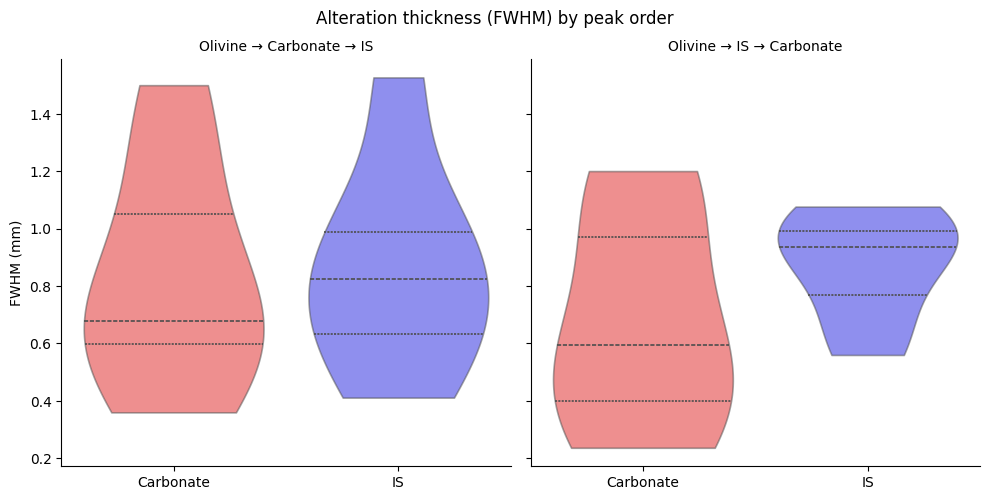

In [33]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --- config (plot-only mappings; does not modify metrics_df) ---
fwhm_cols = {'fwhm_Carb': 'Carb', 'fwhm_IS': 'IS'}

display_names = {
    'Carb': 'Carbonate',
    'IS': 'IS',
}

orders = ['Olivine->Carb->IS', 'Olivine->IS->Carb']


def pretty_peak_order(order: str) -> str:
    """Convert 'Olivine->Carb->IS' -> 'Olivine → Carbonate → IS'."""
    parts = order.split('->')
    parts = [display_names.get(p, p) for p in parts]
    return ' \u2192 '.join(parts)  # arrow: →


# --- tidy data for plotting ---
subset = metrics_df.loc[metrics_df['peak_order'].isin(orders), ['peak_order', *fwhm_cols.keys()]].copy()

long_plot = (
    subset.melt(
        id_vars='peak_order',
        value_vars=list(fwhm_cols.keys()),
        var_name='MineralKey',
        value_name='FWHM',
    )
    .replace({'MineralKey': fwhm_cols})
    .assign(
        FWHM_mm=lambda d: d['FWHM'] * 1000.0,
        MineralLabel=lambda d: d['MineralKey'].replace(display_names),
        peak_order_label=lambda d: d['peak_order'].map(pretty_peak_order),
    )
)

# keep consistent ordering on the x-axis
x_order = ['Carbonate', 'IS']

# color mapping (must match x labels if x is MineralLabel)
palette = {'Carbonate': 'red', 'IS': 'blue'}

col_order = [
    'Olivine → Carbonate → IS',
    'Olivine → IS → Carbonate',
]

g = sns.catplot(
    kind='violin',
    data=long_plot,
    x='MineralLabel',
    y='FWHM_mm',
    order=x_order,
    col='peak_order_label',
    col_order=col_order,      # <-- force panel order (left to right)
    sharey=True,
    inner='quartile',
    cut=0,
    palette=palette,
    linewidth=1.2,
)


g.set_axis_labels('', 'FWHM (mm)')
g.set_titles('{col_name}')
plt.suptitle('Alteration thickness (FWHM) by peak order', y=1.03)

# Optional: make the filled violins semi-transparent (helps compare overlaps/edges)
for ax in g.axes.flat:
    for coll in ax.collections:
        try:
            coll.set_alpha(0.5)
        except Exception:
            pass

plt.savefig(os.path.join(outdir_root, "Violin.png"), dpi=300, bbox_inches='tight')
plt.show()


## 15) Hydrated Carbonate Plots

In [35]:
# --- Drop-in: carbonate opacity + TOTAL (wt%) color overlay (Plotly, uses I_COL/J_COL) ---

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64

def plot_carbonate_total_overlay_plotly(
    df: pd.DataFrame,
    image_path: str,
    carbonate_col: str = None,          # defaults to your mapping for carbonate
    totals_col: str = "TOTAL (wt%)",    # exact column name in your df
    xcol: str = None,                   # defaults to I_COL
    ycol: str = None,                   # defaults to J_COL
    point_size: int = 7
):
    # Defaults from your earlier config/mapping
    if carbonate_col is None:
        carbonate_col = MINERAL_COLS.get("Carb", "Carbonate_wt")
    if xcol is None: xcol = I_COL
    if ycol is None: ycol = J_COL

    needed = [carbonate_col, totals_col, xcol, ycol]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        print(f"Missing columns in df: {missing}")
        return

    # Load background image
    img = Image.open(image_path).convert("RGBA")
    w, h = img.size
    
    #I have to scale the SIF image file specifically since it is a WATSON
    img = img.resize((w//4, h//4), resample=getattr(Image, "Resampling", Image).LANCZOS); w, h = img.size
    
    buf = BytesIO(); img.save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()

    # Data
    x = pd.to_numeric(df[xcol], errors="coerce").to_numpy(float)
    y = pd.to_numeric(df[ycol], errors="coerce").to_numpy(float)
    carb = pd.to_numeric(df[carbonate_col], errors="coerce").to_numpy(float)
    tot  = pd.to_numeric(df[totals_col], errors="coerce").to_numpy(float)

    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(carb) & np.isfinite(tot)
    if not np.any(m):
        print("No valid points to plot.")
        return
    x, y, carb, tot = x[m], y[m], carb[m], tot[m]

    # -------- BALANCED OPACITY BANDS (carbonate drives opacity) --------
    # Lowest carbonate band invisible; generous mid-range visibility; top fully opaque.
    if np.any(np.isfinite(carb)):
        qs = [0, 20, 40, 60, 80, 95, 100]  # 7 edges → 6 bands
        edges = np.percentile(carb, qs).tolist()
        # ensure strict monotonicity even with ties
        for i in range(1, len(edges)):
            if edges[i] <= edges[i-1]:
                edges[i] = edges[i-1] + 1e-12
    else:
        edges = [0, 1, 2, 3, 4, 5, 6]

    band_opacities = [0.00, 0.18, 0.35, 0.55, 0.78, 1.00]

    # Color from TOTAL (wt%): blue (low) → red (high)
    cmin = float(np.nanmin(tot))
    cmax = float(np.nanmax(tot)) if np.nanmax(tot) > cmin else (cmin + 1e-9)
    colorscale = [(0.0, "#0000ff"), (1.0, "#ff0000")]  # blue → red

    # Build figure
    fig = go.Figure()
    fig.add_layout_image(dict(
        source='data:image/png;base64,' + b64,
        xref='x', yref='y', x=0, y=0, sizex=w, sizey=h,
        sizing='stretch', layer='below'
    ))

    # Add 6 opacity-banded traces; only the first shows the colorbar
    for i in range(len(band_opacities)):
        lo, hi = edges[i], edges[i+1]
        mk = (carb >= lo) & (carb <= hi)
        if not np.any(mk):
            continue
        fig.add_trace(go.Scattergl(
            x=x[mk], y=y[mk], mode="markers",
            marker=dict(
                size=point_size,
                symbol="square",              # squares instead of circles
                color=tot[mk],                # TOTAL drives color
                colorscale=colorscale,
                cmin=cmin, cmax=cmax,
                showscale=(i == 0),           # single shared colorbar
                colorbar=dict(title="TOTAL (wt%)", thickness=18),
                opacity=band_opacities[i],
                line=dict(width=0)
            ),
            name="", showlegend=False
        ))

    # Axes & layout
    fig.update_xaxes(visible=False, range=[0, w])
    fig.update_yaxes(visible=False, range=[h, 0], scaleanchor='x')
    fig.update_layout(
        title="Carbonate (opacity) + TOTAL (wt%) (color) Overlay",
        width=800, height=int(800 * h / w),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    return fig

# Example call
plot_carbonate_total_overlay_plotly(df, image_path)